# 1. Import Libraries 

In [2]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'

In [3]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [4]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'AwA2', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs


Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Execution time: 12.88917064666748 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [5]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [6]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,2051:2136]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,2051:2136]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,2051:2136]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,2051:2136]

In [7]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [8]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [9]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [10]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, 85) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [11]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, 85) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [12]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, 85) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [13]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# 8. Define Conventiona Zero Shot Leaning Function

In [15]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)
    
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass      
    
    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,2:87])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=100, metric = 'cosine', perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
      
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction)
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 9. Train Model

### 9.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4282                0.3714        0.3517                0.4577     +  1.6369
      2        0.2994                0.5264        0.2585                0.5972     +  1.4349
      3        0.2313                0.6523        0.2095                0.7082     +  1.5853
      4        0.1933                0.7361        0.1801                0.7700     +  1.5541
      5        0.1690                0.7840        0.1597                0.8050     +  1.4658
      6        0.1512                0.8138        0.1443                0.8309     +  1.4688
      7        0.1376                0.8335        0.1322                0.8487     +  1.5156
      8        0.1266                0.8511        0.1224                0.8622     +  1.4190
      9        0.1177                0.8609    

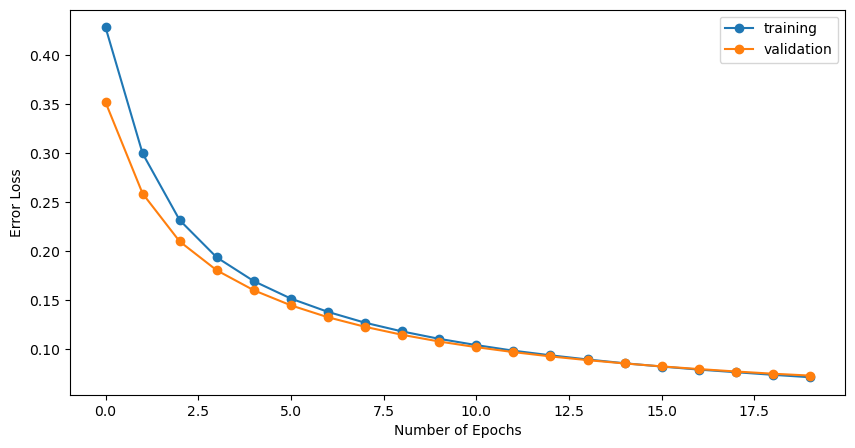

Trianing Recall Macro Curve


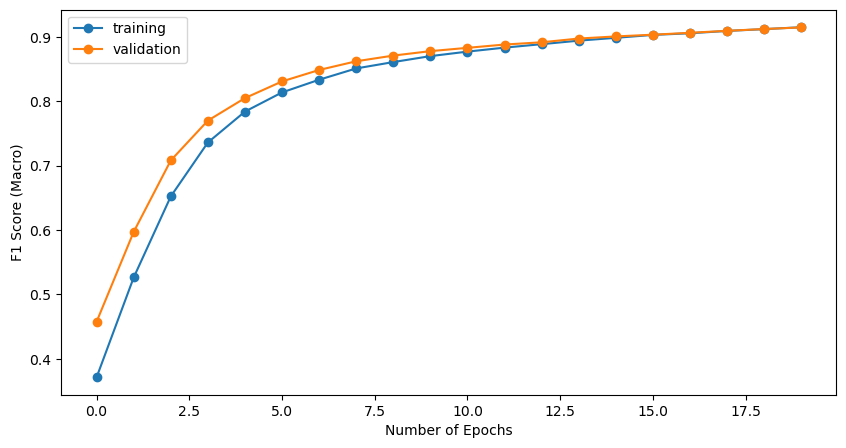

              precision    recall  f1-score   support

       black       0.93      0.96      0.95       882
       white       0.95      0.91      0.93       678
        blue       0.90      0.87      0.89       117
       brown       0.96      0.97      0.96       950
        gray       0.94      0.95      0.95       739
      orange       0.97      0.94      0.96       124
         red       0.98      0.85      0.91        54
      yellow       0.99      0.96      0.98        82
     patches       0.93      0.87      0.90       390
       spots       0.96      0.80      0.87       187
     stripes       1.00      0.95      0.97       180
       furry       0.99      1.00      0.99      1288
    hairless       0.99      0.96      0.97       331
   toughskin       0.99      0.98      0.98       826
         big       0.98      0.98      0.98      1188
       small       0.96      0.96      0.96       512
     bulbous       0.98      0.96      0.97       863
        lean       0.96    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.77      0.58      0.66       152
   dalmatian       0.47      0.45      0.46       442
        mole       0.05      0.49      0.08        75
     leopard       0.46      0.91      0.61       568
       moose       0.70      0.46      0.56       554
     gorilla       0.68      0.28      0.40       709
          ox       0.54      0.97      0.70       588
  chimpanzee       0.44      0.62      0.51       566
     hamster       0.68      0.78      0.73       640
      rabbit       0.51      0.03      0.06       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.91      0.88      0.90      1069
     raccoon       0.54      0.62      0.58       408

    accuracy                           0.54      7340
   macro avg       0.52      0.55      0.48      7340
weighted avg       0.56      0.54      0.50      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.57894737 0.450226

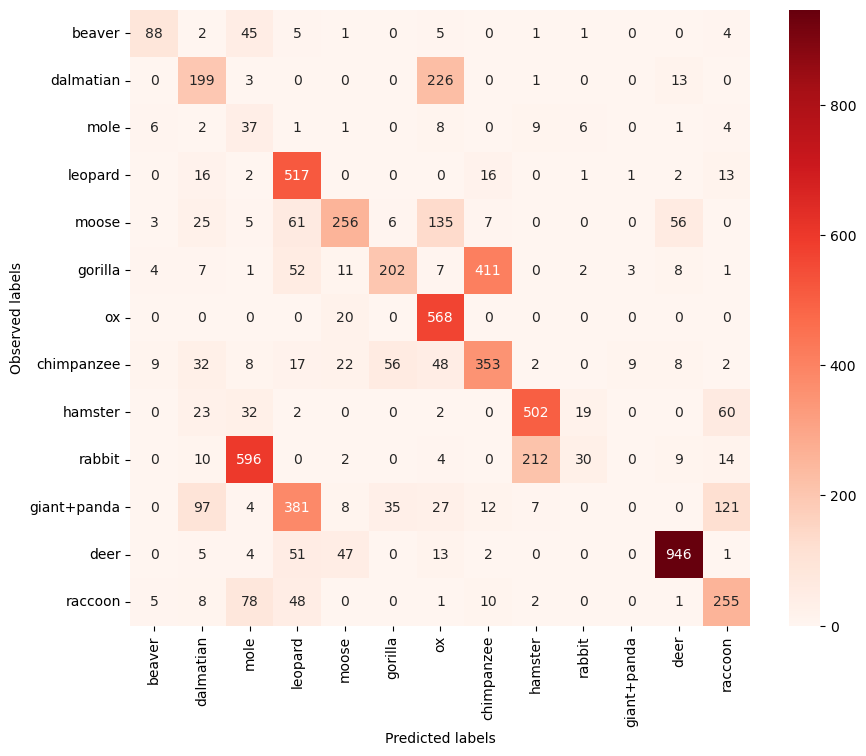

              precision    recall  f1-score   support

ARTIODACTYLA       0.83      0.92      0.87      2211
   CARNIVORA       0.81      0.78      0.80      2110
EULIPOTYPHLA       0.05      0.49      0.08        75
  LAGOMORPHA       0.51      0.03      0.06       877
    PRIMATES       0.92      0.80      0.86      1275
    RODENTIA       0.69      0.75      0.72       792

    accuracy                           0.73      7340
   macro avg       0.63      0.63      0.57      7340
weighted avg       0.78      0.73      0.73      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.92311171 0.78483412 0.49333333 0.03420753 0.80156863 0.74621212]
Top_1_accuracy for UnSeen Validation split 01 -  0.6305445741718864


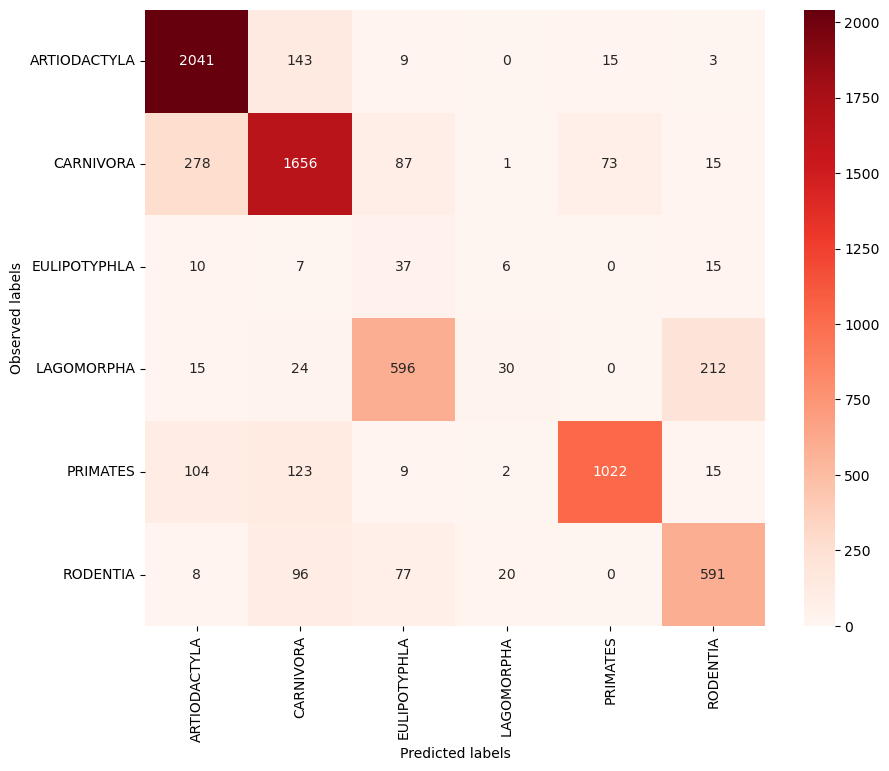

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7142675830635644 
              0         1
0        beaver  0.684211
1     dalmatian  0.619910
2          mole  0.760000
3       leopard  0.950704
4         moose  0.788809
5       gorilla  0.791255
6            ox  1.000000
7    chimpanzee  0.765018
8       hamster  0.914062
9        rabbit  0.187001
10  giant+panda  0.001445
11         deer  0.938260
12      raccoon  0.884804 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7928080809923195 
              0         1
0        beaver  0.723684
1     dalmatian  0.730769
2          mole  0.826667
3       leopard  0.970070
4         moose  0.819495
5       gorilla  0.929478
6            ox  1.000000
7    chimpanzee  0.869258
8       hamster  0.978125
9        rabbit  0.537058
10  giant+panda  0.004335
11         deer  0.981291
12      raccoon  0.936275 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8693261967706096 
              0         1
0        beaver  0.796053
1     

In [28]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4332                0.3839        0.3550                0.4647     +  1.4378
      2        0.3008                0.5522        0.2551                0.6184     +  1.2458
      3        0.2293                0.6861        0.2048                0.7384     +  1.2544
      4        0.1903                0.7734        0.1741                0.8018     +  1.3004
      5        0.1647                0.8187        0.1530                0.8375     +  1.2447
      6        0.1467                0.8461        0.1373                0.8590     +  1.3077
      7        0.1328                0.8636        0.1253                0.8718     +  1.2880
      8        0.1219                0.8762        0.1158                0.8833     +  1.2843
      9        0.1130                0.8868    

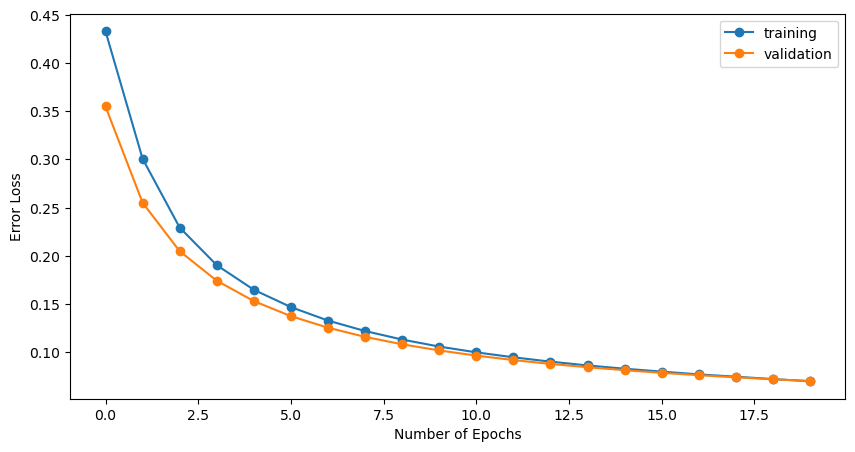

Trianing Recall Macro Curve


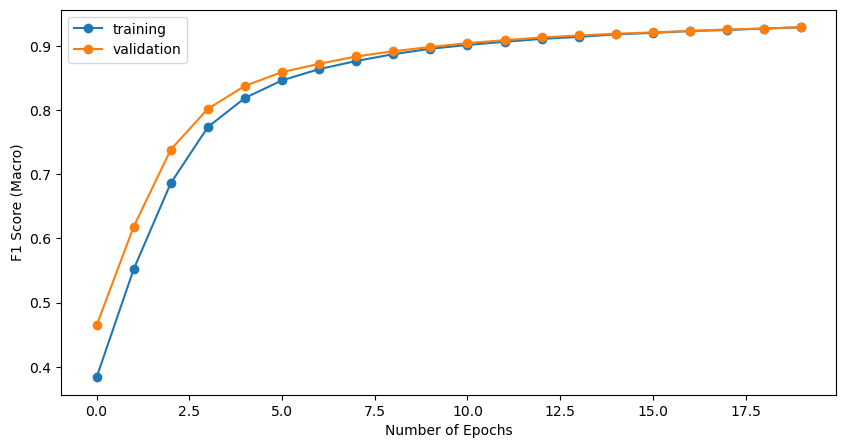

              precision    recall  f1-score   support

       black       0.94      0.96      0.95       974
       white       0.95      0.93      0.94       691
        blue       1.00      1.00      1.00        57
       brown       0.98      0.99      0.99      1173
        gray       0.97      0.96      0.96       778
      orange       1.00      0.97      0.99        70
         red       0.00      0.00      0.00         0
      yellow       1.00      0.97      0.99       139
     patches       0.94      0.95      0.95       737
       spots       0.94      0.91      0.92       382
     stripes       0.99      0.84      0.91       111
       furry       0.99      1.00      1.00      1421
    hairless       1.00      0.97      0.98       252
   toughskin       0.97      0.95      0.96       681
         big       0.99      0.99      0.99      1276
       small       0.97      0.94      0.96       535
     bulbous       0.95      0.96      0.95       934
        lean       0.93    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.66      0.98      0.79       864
grizzly+bear       0.79      0.69      0.74       690
killer+whale       0.95      0.77      0.85       231
      beaver       0.27      0.04      0.07       152
   dalmatian       0.31      0.56      0.40       442
 persian+cat       0.36      0.13      0.19       599
       skunk       0.21      0.34      0.26       157
          ox       0.39      0.89      0.54       588
         fox       0.55      0.76      0.64       540
   chihuahua       0.31      0.57      0.40       448
       otter       0.00      0.00      0.00       592
       zebra       0.98      0.36      0.52       942
         pig       0.13      0.05      0.07       558

    accuracy                           0.50      6803
   macro avg       0.46      0.47      0.42      6803
weighted avg       0.50      0.50      0.46      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.97800926 0.686956

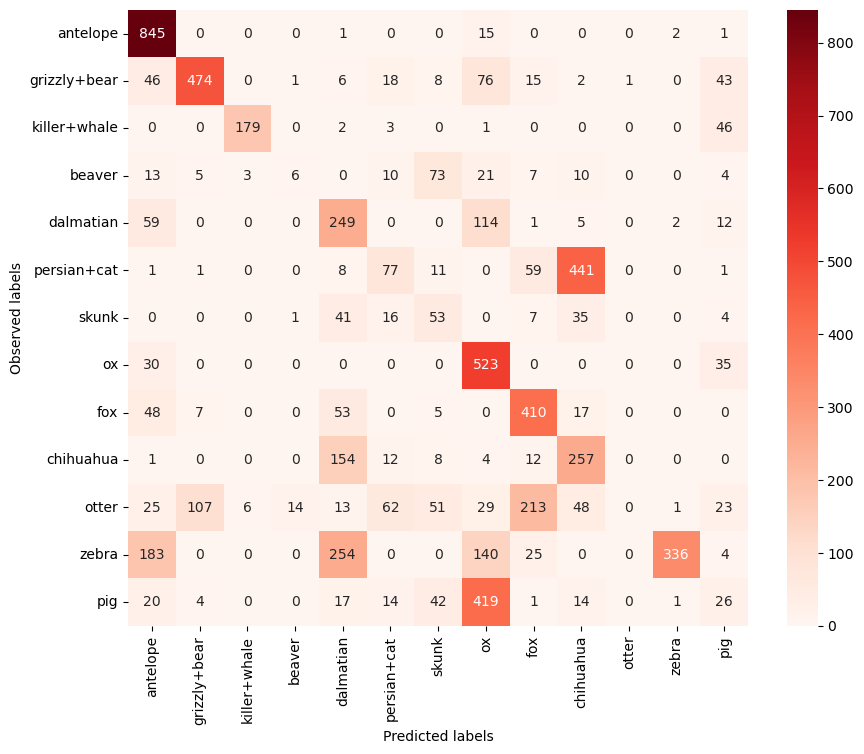

                precision    recall  f1-score   support

  ARTIODACTYLA       0.71      0.95      0.82      2241
     CARNIVORA       0.86      0.85      0.86      3468
PERISSODACTYLA       0.98      0.36      0.52       942
      RODENTIA       0.27      0.04      0.07       152

      accuracy                           0.80      6803
     macro avg       0.71      0.55      0.57      6803
  weighted avg       0.82      0.80      0.78      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95493083 0.85265283 0.3566879  0.03947368]
Top_1_accuracy for UnSeen Validation split 01 -  0.5509363106462054


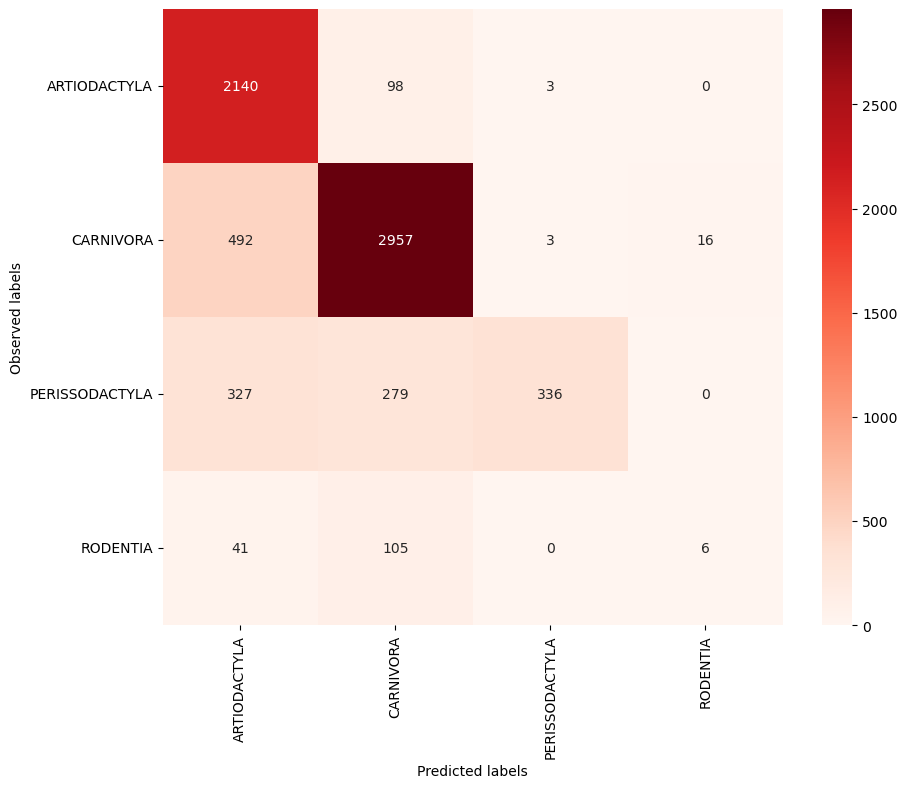

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6879515036692084 
               0         1
0       antelope  0.986111
1   grizzly+bear  0.734783
2   killer+whale  0.800866
3         beaver  0.105263
4      dalmatian  0.662896
5    persian+cat  0.687813
6          skunk  0.585987
7             ox  0.996599
8            fox  0.857407
9      chihuahua  0.941964
10         otter  0.010135
11         zebra  0.828025
12           pig  0.745520 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7671049156209793 
               0         1
0       antelope  1.000000
1   grizzly+bear  0.788406
2   killer+whale  0.805195
3         beaver  0.223684
4      dalmatian  0.846154
5    persian+cat  0.889816
6          skunk  0.713376
7             ox  1.000000
8            fox  0.900000
9      chihuahua  0.977679
10         otter  0.045608
11         zebra  0.943737
12           pig  0.838710 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.829295437483905 
               0         1
0   

In [22]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 9.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4208                0.3730        0.3458                0.4563     +  1.3002
      2        0.2947                0.5222        0.2509                0.5868     +  1.0168
      3        0.2257                0.6328        0.2009                0.6764     +  1.0075
      4        0.1858                0.7149        0.1695                0.7511     +  1.0176
      5        0.1593                0.7747        0.1477                0.8015     +  1.0050
      6        0.1404                0.8174        0.1316                0.8356     +  1.0077
      7        0.1259                0.8466        0.1193                0.8591     +  1.0132
      8        0.1143                0.8662        0.1096                0.8741     +  0.9922
      9        0.1056                0.8797    

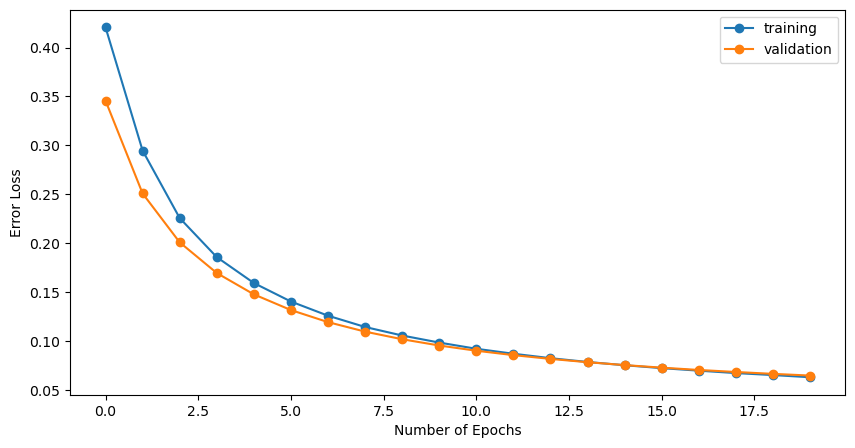

Trianing Recall Macro Curve


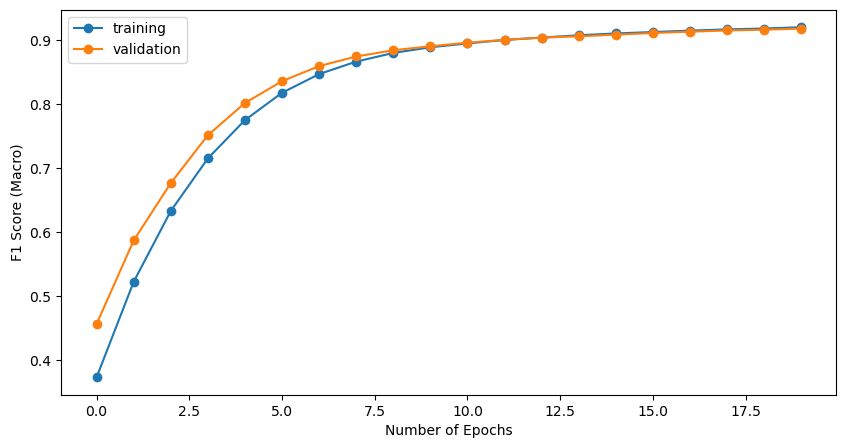

              precision    recall  f1-score   support

       black       0.94      0.96      0.95       918
       white       0.98      0.95      0.96       702
        blue       0.94      0.83      0.88        60
       brown       0.97      0.98      0.97      1025
        gray       0.92      0.92      0.92       451
      orange       0.96      0.94      0.95       124
         red       0.94      0.91      0.92        54
      yellow       1.00      0.94      0.97       139
     patches       0.92      0.90      0.91       566
       spots       0.91      0.86      0.88       339
     stripes       0.99      0.97      0.98       180
       furry       1.00      1.00      1.00      1463
    hairless       0.95      0.91      0.93       265
   toughskin       0.95      0.97      0.96       802
         big       0.98      0.99      0.99      1310
       small       0.96      0.91      0.94       396
     bulbous       0.96      0.98      0.97       911
        lean       0.97    

alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.43      0.74      0.54       400
         moose       0.46      0.75      0.57       554
humpback+whale       0.98      0.96      0.97       565
    chimpanzee       0.85      0.91      0.88       566
      squirrel       0.64      0.57      0.60       961
    rhinoceros       0.83      0.70      0.76       561
        rabbit       0.67      0.74      0.70       877
          wolf       0.50      0.74      0.60       470
     chihuahua       0.46      0.28      0.35       448
        weasel       0.08      0.33      0.13       222
   giant+panda       0.00      0.00      0.00       692
           pig       0.56      0.37      0.45       558
       raccoon       0.80      0.01      0.02       408

      accuracy                           0.56      7282
     macro avg       0.56      0.55      0.51      7282
  weighted avg       0.58      0.56      0.54      7282

Top_1_accuracy for UnSeen Validation split 01

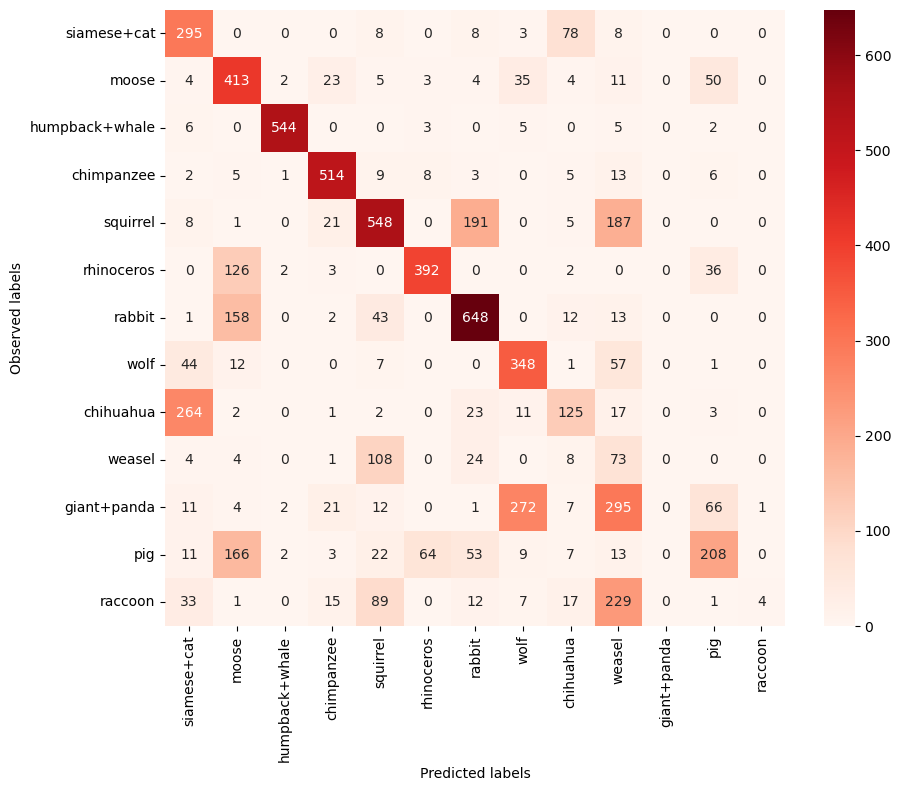

                precision    recall  f1-score   support

  ARTIODACTYLA       0.76      0.83      0.79      1677
     CARNIVORA       0.86      0.84      0.85      2640
    LAGOMORPHA       0.67      0.74      0.70       877
PERISSODACTYLA       0.83      0.70      0.76       561
      PRIMATES       0.85      0.91      0.88       566
      RODENTIA       0.64      0.57      0.60       961

      accuracy                           0.78      7282
     macro avg       0.77      0.76      0.76      7282
  weighted avg       0.78      0.78      0.78      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.82707215 0.83787879 0.73888255 0.69875223 0.90812721 0.57023933]
Top_1_accuracy for UnSeen Validation split 01 -  0.763492044227644


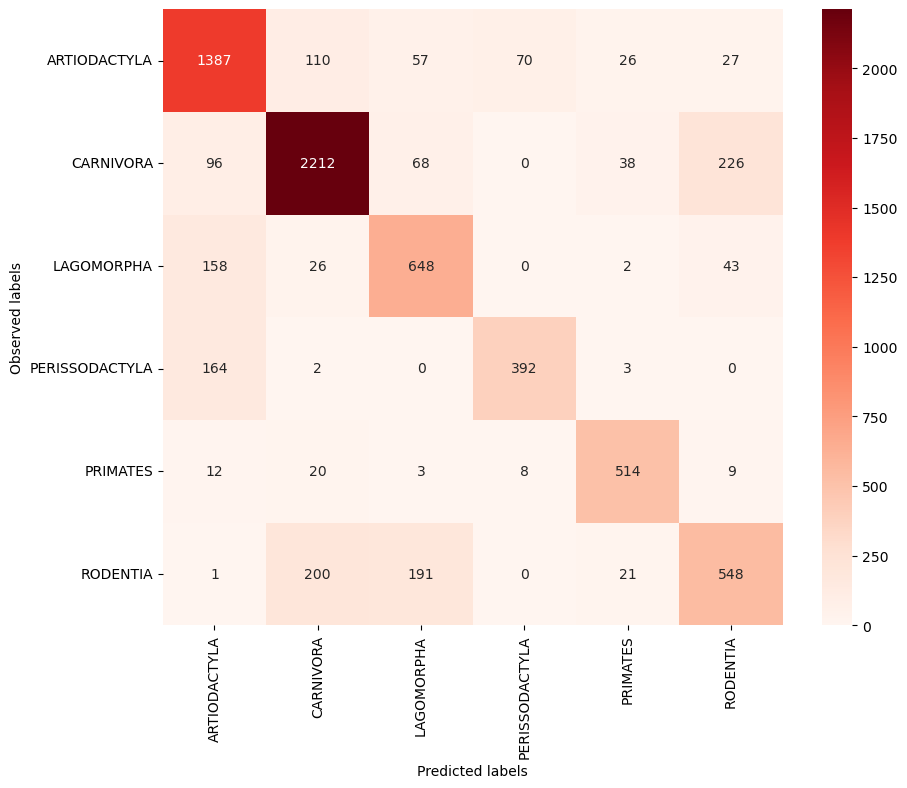

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7199503440672907 
                 0         1
0      siamese+cat  0.910000
1            moose  0.851986
2   humpback+whale  0.971681
3       chimpanzee  0.924028
4         squirrel  0.907388
5       rhinoceros  0.848485
6           rabbit  0.883694
7             wolf  0.887234
8        chihuahua  0.837054
9           weasel  0.621622
10     giant+panda  0.001445
11             pig  0.655914
12         raccoon  0.058824 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8006522295997599 
                 0         1
0      siamese+cat  0.955000
1            moose  0.895307
2   humpback+whale  0.978761
3       chimpanzee  0.936396
4         squirrel  0.951093
5       rhinoceros  0.989305
6           rabbit  0.982896
7             wolf  0.931915
8        chihuahua  0.933036
9           weasel  0.873874
10     giant+panda  0.007225
11             pig  0.784946
12         raccoon  0.188725 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [23]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 10. Hyperoptimisation

In [17]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Sigmoid())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, 85))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 8, 64)
    ep = trial.suggest_int("max_epoch", 5, 200)
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict(ValData01.iloc[:,1:2049].astype(np.float32).values)
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,2:87])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen1, animal_attributes1, 'euclidean'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict(ValData02.iloc[:,1:2049].astype(np.float32).values)
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,2:87])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen2, animal_attributes2, 'euclidean'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict(ValData03.iloc[:,1:2049].astype(np.float32).values)
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,2:87])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen3, animal_attributes3, 'euclidean'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [18]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="skorch example.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 02:57:02,309] A new study created in memory with name: no-name-040bf2d0-1951-4ad4-acfa-4e44beae0ac6


Sequential(
  (0): Linear(in_features=2048, out_features=126, bias=True)
  (1): Dropout(p=0.16433716398256115, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=126, out_features=4, bias=True)
  (4): Dropout(p=0.16433716398256115, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=10, bias=True)
  (7): Dropout(p=0.16433716398256115, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=10, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=126, bias=True)
  (1): Dropout(p=0.16433716398256115, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=126, out_features=4, bias=True)
  (4): Dropout(p=0.16433716398256115, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=10, bias=True)
  (7): Dropout(p=0.16433716398256115, inplace=False)
  (8): Sigmoid()
  (9): Linear(in_features=10, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=126, bias=True)
  (1): Drop

[I 2022-12-10 02:57:34,707] Trial 0 finished with value: 0.07692307692307693 and parameters: {'lr': 0.02104733816508337, 'batch_size': 14, 'max_epoch': 6, 'n_layers': 3, 'dropout': 0.16433716398256115, 'n_units_l0': 126, 'n_units_l1': 4, 'n_units_l2': 10}. Best is trial 0 with value: 0.07692307692307693.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.1977373455537655, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=6, out_features=34, bias=True)
  (4): Dropout(p=0.1977373455537655, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=34, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.1977373455537655, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=6, out_features=34, bias=True)
  (4): Dropout(p=0.1977373455537655, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_features=34, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.1977373455537655, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=6, out_features=34, bias=True)
  (4): Dropout(p=0.1977373455537655, inplace=False)
  (5): Sigmoid()
  (6): Linear(in_f

     15        0.4859        0.4848                0.3285  0.5771
     16        0.4854        0.4843                0.3284  0.5434
     17        0.4850        0.4838                0.3284  0.5110
     18        0.4846        0.4833                0.3280  0.5342
     19        0.4841        0.4828                0.3273  0.5058
     20        0.4837        0.4823                0.3265  0.5191
     21        0.4833        0.4818                0.3267  0.5030
     22        0.4829        0.4812                0.3268  0.5002
     23        0.4823        0.4806                0.3271  0.5105
     24        0.4819        0.4801                0.3274  0.5211
     25        0.4814        0.4794                0.3277  0.5526
     26        0.4809        0.4788                0.3276  0.5175
     27        0.4804        0.4781                0.3273  0.5620
     28        0.4798        0.4774                0.3270  0.5330
     29        0.4792        0.4766                0.3267  0.5202
     30   

     43        0.4375        0.4289                0.3647  0.4736
     44        0.4355        0.4267                0.3700  0.5236
     45        0.4334        0.4243                0.3765  0.5364
     46        0.4314        0.4220                0.3810  0.5150
     47        0.4294        0.4196                0.3812  0.5086
     48        0.4274        0.4173                0.3815  0.5236
     49        0.4252        0.4149                0.3820  0.4655
     50        0.4230        0.4126                0.3839  0.4987
     51        0.4211        0.4103                0.3919  0.4774
     52        0.4191        0.4081                0.3980  0.4918
     53        0.4168        0.4059                0.4005  0.4756
     54        0.4151        0.4038                0.4016  0.4841
     55        0.4131        0.4019                0.4022  0.4883
     56        0.4112        0.4000                0.4056  0.5003
     57        0.4091        0.3982                0.4135  0.4950
     58   

[I 2022-12-10 02:59:26,296] Trial 1 finished with value: 0.1701723576834536 and parameters: {'lr': 0.0898317903540705, 'batch_size': 50, 'max_epoch': 65, 'n_layers': 2, 'dropout': 0.1977373455537655, 'n_units_l0': 6, 'n_units_l1': 34}. Best is trial 1 with value: 0.1701723576834536.


[0.19831101508844182, 0.16660011176322664, 0.14560594619869227]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.39113456771838406, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.39113456771838406, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.39113456771838406, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.7056        0.6955                0.4938  0.4638
      2        0.6955        0.6878                0.4553  0.5159
      3        0.6889        0.6813                0.4317  0.4782
      

     89        0.4801        0.4695                0.3083  0.4511
     90        0.4796        0.4691                0.3096  0.5059
     91        0.4791        0.4686                0.3108  0.5276
     92        0.4788        0.4682                0.3119  0.4557
     93        0.4783        0.4678                0.3129  0.4720
     94        0.4781        0.4673                0.3139  0.4559
     95        0.4777        0.4669                0.3151  0.4673
     96        0.4771        0.4665                0.3161  0.4701
     97        0.4767        0.4660                0.3172  0.4665
     98        0.4765        0.4656                0.3181  0.4510
     99        0.4761        0.4652                0.3189  0.4657
    100        0.4757        0.4648                0.3199  0.4933
    101        0.4756        0.4644                0.3208  0.4636
    102        0.4750        0.4640                0.3215  0.4999
    103        0.4744        0.4636                0.3222  0.4847
    104   

     27        0.5357        0.5200                0.3013  0.4970
     28        0.5330        0.5173                0.3010  0.4739
     29        0.5304        0.5148                0.3008  0.4963
     30        0.5277        0.5124                0.3009  0.5027
     31        0.5257        0.5101                0.3006  0.4868
     32        0.5235        0.5080                0.3012  0.4967
     33        0.5216        0.5060                0.3010  0.5159
     34        0.5198        0.5041                0.3014  0.4568
     35        0.5178        0.5024                0.3020  0.4945
     36        0.5162        0.5007                0.3029  0.4759
     37        0.5143        0.4991                0.3041  0.4599
     38        0.5127        0.4977                0.3062  0.4839
     39        0.5113        0.4963                0.3087  0.5208
     40        0.5099        0.4949                0.3115  0.4551
     41        0.5086        0.4936                0.3134  0.4839
     42   

    125        0.4676        0.4510                0.3449  0.5460
    126        0.4671        0.4507                0.3454  0.5331
    127        0.4670        0.4504                0.3459  0.5501
    128        0.4668        0.4500                0.3464  0.5139
    129        0.4665        0.4497                0.3468  0.4439
    130        0.4662        0.4494                0.3473  0.5460
    131        0.4662        0.4491                0.3477  0.5793
    132        0.4655        0.4487                0.3482  0.5813
    133        0.4656        0.4484                0.3486  0.5619
    134        0.4654        0.4481                0.3491  0.5181
    135        0.4650        0.4478                0.3496  0.4347
    136        0.4644        0.4474                0.3501  0.4606
    137        0.4645        0.4471                0.3505  0.5854
    138        0.4644        0.4468                0.3511  0.4985
    139        0.4641        0.4465                0.3516  0.4446
    140   

     64        0.4831        0.4684                0.3354  0.4102
     65        0.4822        0.4677                0.3362  0.4277
     66        0.4812        0.4669                0.3368  0.4321
     67        0.4807        0.4662                0.3375  0.4300
     68        0.4800        0.4655                0.3380  0.4255
     69        0.4794        0.4649                0.3385  0.4355
     70        0.4785        0.4642                0.3390  0.4340
     71        0.4779        0.4636                0.3393  0.4840
     72        0.4774        0.4629                0.3399  0.5104
     73        0.4766        0.4623                0.3403  0.5002
     74        0.4761        0.4617                0.3408  0.4813
     75        0.4754        0.4611                0.3410  0.4870
     76        0.4749        0.4605                0.3412  0.4767
     77        0.4743        0.4599                0.3416  0.4968
     78        0.4737        0.4594                0.3419  0.4684
     79   

[I 2022-12-10 03:03:32,737] Trial 2 finished with value: 0.11704319042198162 and parameters: {'lr': 0.013462646004607514, 'batch_size': 57, 'max_epoch': 158, 'n_layers': 1, 'dropout': 0.39113456771838406, 'n_units_l0': 7}. Best is trial 1 with value: 0.1701723576834536.


[0.0778039637163944, 0.06815524163602514, 0.2051703659135253]
Sequential(
  (0): Linear(in_features=2048, out_features=167, bias=True)
  (1): Dropout(p=0.10237869116860616, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=167, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=167, bias=True)
  (1): Dropout(p=0.10237869116860616, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=167, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=167, bias=True)
  (1): Dropout(p=0.10237869116860616, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=167, out_features=85, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6489        0.5859                0.3327  1.2070
      2        0.5490        0.5221                0.3062  1.0272
      3        0.5068        0.4969                0.3010  1.0

     24        0.3971        0.3921                0.4280  1.4766
     25        0.3925        0.3874                0.4339  1.5104
     26        0.3880        0.3828                0.4401  1.5806
     27        0.3835        0.3782                0.4465  1.6400
     28        0.3792        0.3738                0.4527  1.6854
     29        0.3749        0.3695                0.4579  1.4640
     30        0.3708        0.3653                0.4632  1.5073
     31        0.3668        0.3612                0.4676  1.4934
     32        0.3628        0.3572                0.4715  1.5281
     33        0.3590        0.3533                0.4755  1.4907
     34        0.3553        0.3494                0.4796  1.5221
     35        0.3517        0.3457                0.4842  1.6105
     36        0.3481        0.3421                0.4885  2.0854
     37        0.3446        0.3386                0.4929  2.2415
     38        0.3411        0.3351                0.4972  2.0597
     39   

     54        0.2881        0.2813                0.5401  1.8462
     55        0.2857        0.2790                0.5435  1.9151
     56        0.2836        0.2768                0.5475  1.9452
     57        0.2813        0.2746                0.5509  1.7663


[I 2022-12-10 03:08:35,901] Trial 3 finished with value: 0.34159254996495486 and parameters: {'lr': 0.004320737224068336, 'batch_size': 14, 'max_epoch': 57, 'n_layers': 1, 'dropout': 0.10237869116860616, 'n_units_l0': 167}. Best is trial 3 with value: 0.34159254996495486.


[0.33076191234825675, 0.3484286352337824, 0.34558710231282536]
Sequential(
  (0): Linear(in_features=2048, out_features=369, bias=True)
  (1): Dropout(p=0.2174459259766949, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=369, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=369, bias=True)
  (1): Dropout(p=0.2174459259766949, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=369, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=369, bias=True)
  (1): Dropout(p=0.2174459259766949, inplace=False)
  (2): Sigmoid()
  (3): Linear(in_features=369, out_features=85, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6311        0.5740                0.3137  0.7559
      2        0.5433        0.5216                0.3011  0.6837
      3        0.5082        0.4997                0.2924  0.699

     82        0.2951        0.2867                0.5445  0.6566
     83        0.2936        0.2851                0.5466  0.7004
     84        0.2920        0.2836                0.5489  0.6855
     85        0.2906        0.2820                0.5519  0.7069
     86        0.2891        0.2805                0.5548  0.6710
     87        0.2876        0.2790                0.5576  0.6758
     88        0.2862        0.2775                0.5603  0.6575
     89        0.2848        0.2760                0.5627  0.7097
     90        0.2834        0.2746                0.5657  0.6680
     91        0.2820        0.2732                0.5685  0.6246
     92        0.2807        0.2717                0.5719  0.6946
     93        0.2793        0.2703                0.5744  0.7540
     94        0.2778        0.2690                0.5776  0.7053
     95        0.2765        0.2676                0.5799  0.6854
     96        0.2753        0.2662                0.5833  0.6499
     97   

    171        0.2063        0.1973                0.7581  0.6757
    172        0.2056        0.1967                0.7596  0.6126
    173        0.2050        0.1961                0.7606  0.6132
    174        0.2044        0.1955                0.7617  0.6494
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6306        0.5729                0.2955  0.7468
      2        0.5445        0.5221                0.3110  0.6945
      3        0.5110        0.5010                0.3165  0.6923
      4        0.4963        0.4910                0.3215  0.7113
      5        0.4887        0.4852                0.3240  0.7024
      6        0.4841        0.4813                0.3255  0.7495
      7        0.4807        0.4783                0.3264  0.8021
      8        0.4779        0.4757                0.3275  0.7212
      9        0.4755        0.4733                0.3288  0.7232
     10   

     84        0.2949        0.2841                0.5794  0.7707
     85        0.2933        0.2825                0.5818  0.7658
     86        0.2918        0.2809                0.5845  0.7596
     87        0.2904        0.2794                0.5871  0.8228
     88        0.2889        0.2778                0.5900  0.7966
     89        0.2873        0.2763                0.5925  0.7613
     90        0.2859        0.2748                0.5957  0.7494
     91        0.2845        0.2734                0.5987  0.7828
     92        0.2831        0.2719                0.6014  0.7557
     93        0.2817        0.2705                0.6041  0.7464
     94        0.2803        0.2690                0.6070  0.7613
     95        0.2788        0.2676                0.6102  0.8436
     96        0.2775        0.2663                0.6130  0.7313
     97        0.2761        0.2649                0.6163  0.7441
     98        0.2748        0.2635                0.6191  0.7394
     99   

    173        0.2060        0.1946                0.7843  0.7223
    174        0.2053        0.1940                0.7861  0.7348
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6188        0.5611                0.2759  0.6991
      2        0.5322        0.5092                0.2945  0.6724
      3        0.4978        0.4872                0.3074  0.7037
      4        0.4823        0.4766                0.3129  0.6582
      5        0.4743        0.4706                0.3172  0.7178
      6        0.4694        0.4665                0.3205  0.7192
      7        0.4660        0.4635                0.3228  0.6229
      8        0.4632        0.4609                0.3247  0.7073
      9        0.4608        0.4585                0.3265  0.6901
     10        0.4586        0.4563                0.3279  0.6877
     11        0.4565        0.4541                0.3297  0.7503
     12   

     86        0.2847        0.2744                0.5532  0.6366
     87        0.2833        0.2729                0.5555  0.6035
     88        0.2819        0.2715                0.5581  0.6395
     89        0.2805        0.2700                0.5607  0.6301
     90        0.2790        0.2686                0.5634  0.6386
     91        0.2776        0.2672                0.5653  0.6204
     92        0.2763        0.2658                0.5674  0.6378
     93        0.2750        0.2644                0.5700  0.6369
     94        0.2737        0.2630                0.5721  0.6897
     95        0.2723        0.2617                0.5744  0.6347
     96        0.2710        0.2604                0.5767  0.6716
     97        0.2698        0.2591                0.5787  0.6329
     98        0.2685        0.2578                0.5810  0.6978
     99        0.2672        0.2565                0.5834  0.7401
    100        0.2660        0.2552                0.5852  0.6123
    101   

[I 2022-12-10 03:15:12,694] Trial 4 finished with value: 0.4431561000196807 and parameters: {'lr': 0.007253242555311548, 'batch_size': 45, 'max_epoch': 174, 'n_layers': 1, 'dropout': 0.2174459259766949, 'n_units_l0': 369}. Best is trial 4 with value: 0.4431561000196807.


[0.4347377794381998, 0.4389641110260323, 0.45576640959481013]
Number of finished trials: 5
Best trial:
  Value: 0.4431561000196807
  Params: 
    lr: 0.007253242555311548
    batch_size: 45
    max_epoch: 174
    n_layers: 1
    dropout: 0.2174459259766949
    n_units_l0: 369


# 11. Retrain with best parameters on three train val splits

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5411                0.2973        0.4920                0.2881     +  0.6972
      2        0.4849                0.3061        0.4792                0.3034     +  0.4623
      3        0.4762                0.3135        0.4726                0.3157     +  0.5351
      4        0.4696                0.3204        0.4664                0.3272     +  0.5284
      5        0.4634                0.3271        0.4599                0.3363     +  0.5119
      6        0.4565                0.3347        0.4528                0.3436     +  0.5256
      7        0.4492                0.3425        0.4451                0.3502     +  0.5492
      8        0.4410                0.3521        0.4368                0.3588     +  0.5887
      9        0.4325                0.3617    

     63        0.1933                0.7360        0.1915                0.7428     +  0.5614
     64        0.1915                0.7407        0.1899                0.7461     +  0.5506
     65        0.1899                0.7430        0.1884                0.7495     +  0.5879
     66        0.1886                0.7472        0.1869                0.7526     +  0.5989
     67        0.1870                0.7507        0.1854                0.7555     +  0.5862
     68        0.1855                0.7521        0.1839                0.7584     +  0.5050
     69        0.1840                0.7550        0.1825                0.7606     +  0.5201
     70        0.1827                0.7592        0.1811                0.7629     +  0.5135
     71        0.1812                0.7610        0.1798                0.7662     +  0.5064
     72        0.1799                0.7638        0.1784                0.7694     +  0.5931
     73        0.1786                0.7674        0.1771   

    127        0.1310                0.8456        0.1297                0.8499     +  0.6143
    128        0.1301                0.8471        0.1291                0.8507     +  0.5883
    129        0.1297                0.8475        0.1285                0.8519     +  0.6214
    130        0.1294                0.8478        0.1279                0.8527     +  0.5940
    131        0.1288                0.8491        0.1274                0.8539     +  0.5608
    132        0.1281                0.8494        0.1268                0.8547     +  0.5815
    133        0.1275                0.8515        0.1262                0.8553     +  0.5506
    134        0.1270                0.8514        0.1257                0.8563     +  0.5692
    135        0.1264                0.8525        0.1251                0.8573     +  0.4877
    136        0.1259                0.8531        0.1246                0.8578     +  0.4875
    137        0.1254                0.8535        0.1240   

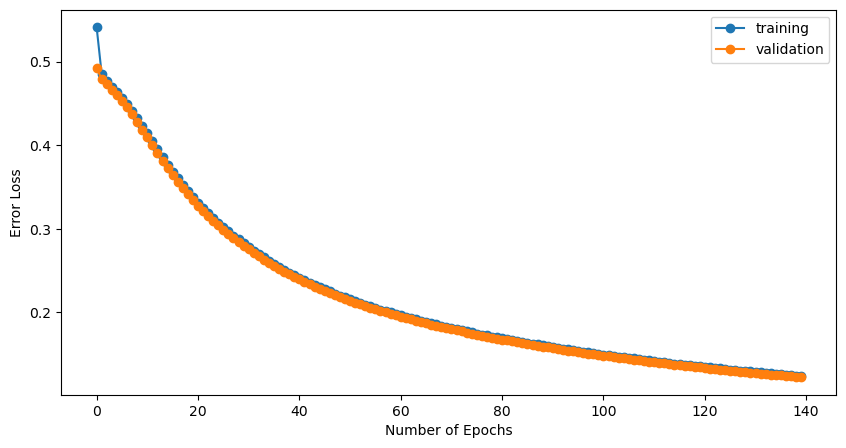

Trianing Recall Macro Curve


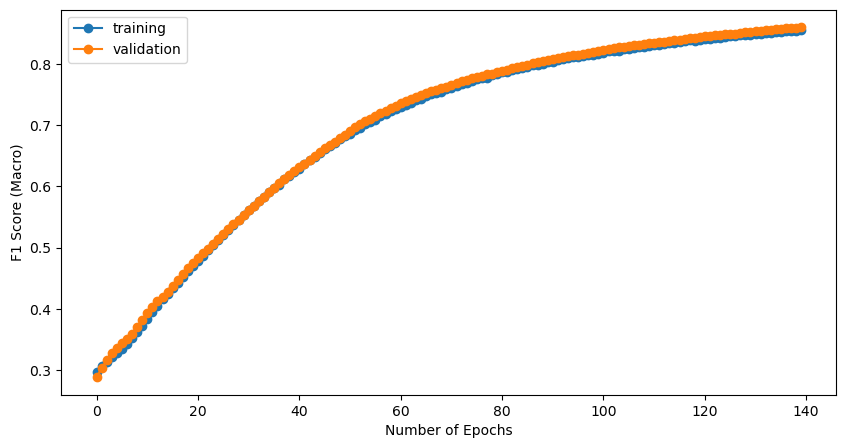

              precision    recall  f1-score   support

       black       0.88      0.91      0.90       882
       white       0.93      0.84      0.88       678
        blue       0.80      0.77      0.78       117
       brown       0.94      0.96      0.95       950
        gray       0.92      0.90      0.91       739
      orange       0.99      0.80      0.88       124
         red       1.00      0.43      0.60        54
      yellow       1.00      0.88      0.94        82
     patches       0.88      0.78      0.83       390
       spots       0.97      0.61      0.75       187
     stripes       1.00      0.91      0.95       180
       furry       0.98      1.00      0.99      1288
    hairless       0.98      0.92      0.95       331
   toughskin       0.97      0.98      0.98       826
         big       0.98      0.98      0.98      1188
       small       0.95      0.94      0.95       512
     bulbous       0.97      0.94      0.96       863
        lean       0.95    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.44      0.57      0.50       152
   dalmatian       0.21      0.61      0.31       442
        mole       0.04      0.72      0.08        75
     leopard       0.45      0.65      0.53       568
       moose       0.54      0.51      0.53       554
     gorilla       0.56      0.52      0.54       709
          ox       0.59      0.90      0.71       588
  chimpanzee       0.57      0.01      0.01       566
     hamster       0.72      0.32      0.44       640
      rabbit       0.29      0.01      0.02       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.82      0.86      0.84      1069
     raccoon       0.77      0.36      0.49       408

    accuracy                           0.44      7340
   macro avg       0.46      0.46      0.38      7340
weighted avg       0.50      0.44      0.41      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.57236842 0.606334

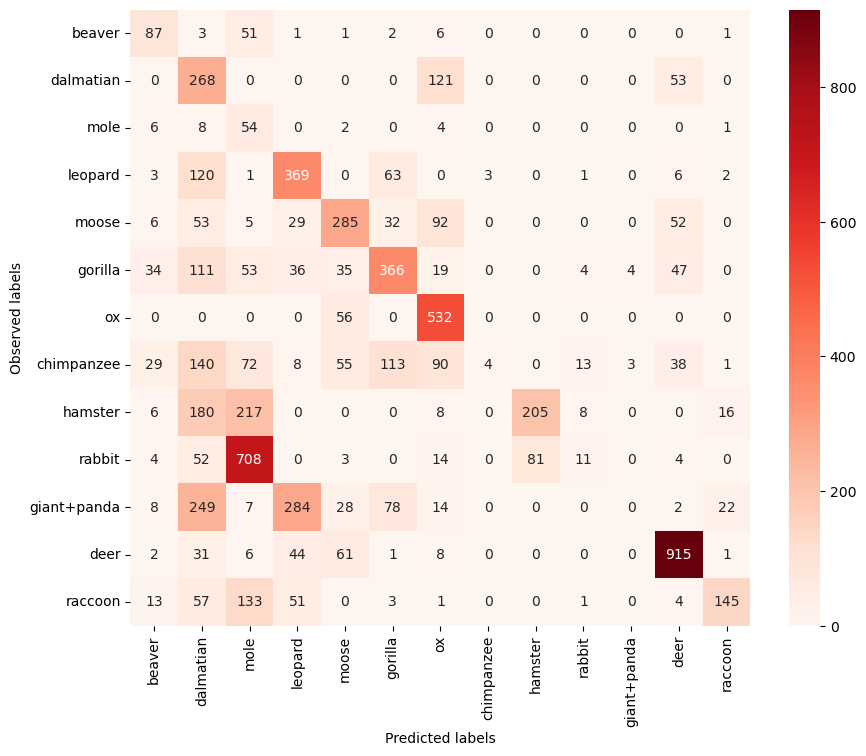

              precision    recall  f1-score   support

ARTIODACTYLA       0.78      0.91      0.84      2211
   CARNIVORA       0.68      0.74      0.71      2110
EULIPOTYPHLA       0.04      0.72      0.08        75
  LAGOMORPHA       0.29      0.01      0.02       877
    PRIMATES       0.73      0.38      0.50      1275
    RODENTIA       0.62      0.38      0.47       792

    accuracy                           0.60      7340
   macro avg       0.52      0.52      0.44      7340
weighted avg       0.66      0.60      0.60      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.90502035 0.74265403 0.72       0.01254276 0.37882353 0.37626263]
Top_1_accuracy for UnSeen Validation split 01 -  0.5225505493831711


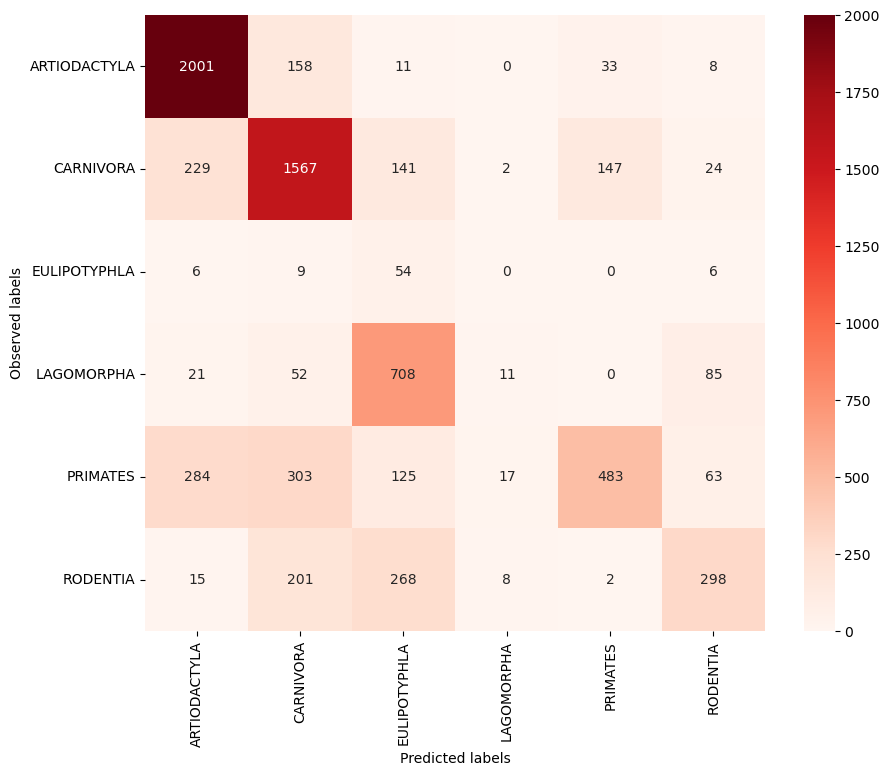

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6341253965218802 
              0         1
0        beaver  0.697368
1     dalmatian  0.703620
2          mole  0.813333
3       leopard  0.845070
4         moose  0.743682
5       gorilla  0.667137
6            ox  1.000000
7    chimpanzee  0.074205
8       hamster  0.773438
9        rabbit  0.202965
10  giant+panda  0.004335
11         deer  0.931712
12      raccoon  0.786765 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7618810441113241 
              0         1
0        beaver  0.815789
1     dalmatian  0.893665
2          mole  0.853333
3       leopard  0.941901
4         moose  0.817690
5       gorilla  0.801128
6            ox  1.000000
7    chimpanzee  0.185512
8       hamster  0.939063
9        rabbit  0.785633
10  giant+panda  0.007225
11         deer  0.973807
12      raccoon  0.889706 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8209760456280333 
              0         1
0        beaver  0.881579
1     

In [29]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5445                0.3168        0.4938                0.3222     +  0.8592
      2        0.4891                0.3228        0.4811                0.3261     +  0.5462
      3        0.4807                0.3271        0.4746                0.3275     +  0.5146
      4        0.4745                0.3317        0.4686                0.3292     +  0.5198
      5        0.4684                0.3373        0.4624                0.3324     +  0.5203
      6        0.4618                0.3432        0.4557                0.3384     +  0.5502
      7        0.4550                0.3504        0.4484                0.3458     +  0.5884
      8        0.4473                0.3595        0.4406                0.3558     +  0.4988
      9        0.4391                0.3693    

     63        0.1899                0.7755        0.1862                0.7792     +  0.5093
     64        0.1880                0.7785        0.1845                0.7823     +  0.5690
     65        0.1865                0.7816        0.1829                0.7852     +  0.5748
     66        0.1850                0.7841        0.1813                0.7884     +  0.5771
     67        0.1833                0.7879        0.1797                0.7916     +  0.5155
     68        0.1821                0.7903        0.1782                0.7946     +  0.5728
     69        0.1805                0.7929        0.1767                0.7972     +  0.5224
     70        0.1790                0.7951        0.1752                0.8009     +  0.5622
     71        0.1774                0.7985        0.1738                0.8033     +  0.6005
     72        0.1762                0.8006        0.1724                0.8057     +  0.5661
     73        0.1748                0.8022        0.1710   

    127        0.1255                0.8739        0.1226                0.8763     +  0.5758
    128        0.1251                0.8741        0.1220                0.8768     +  0.5629
    129        0.1243                0.8756        0.1214                0.8776     +  0.5634
    130        0.1238                0.8758        0.1208                0.8782     +  0.6142
    131        0.1232                0.8753        0.1202                0.8787     +  0.5878
    132        0.1228                0.8771        0.1197                0.8794     +  0.6091
    133        0.1221                0.8778        0.1191                0.8800     +  0.5772
    134        0.1217                0.8785        0.1186                0.8811     +  0.5675
    135        0.1210                0.8797        0.1181                0.8818     +  0.6003
    136        0.1207                0.8796        0.1175                0.8823     +  0.6235
    137        0.1198                0.8803        0.1170   

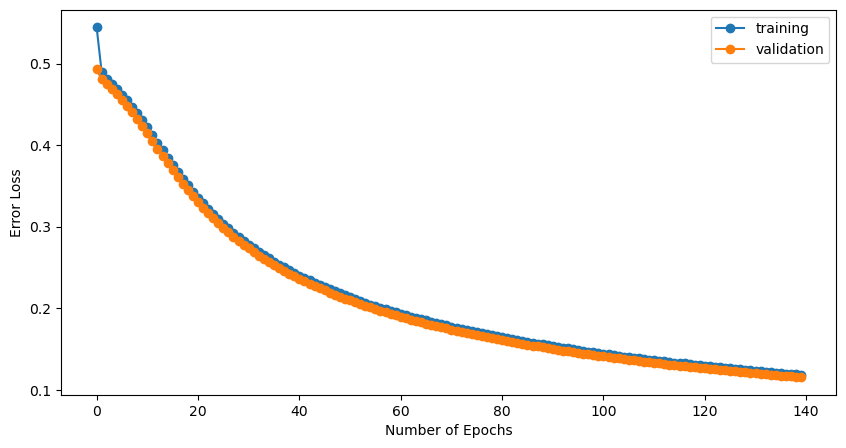

Trianing Recall Macro Curve


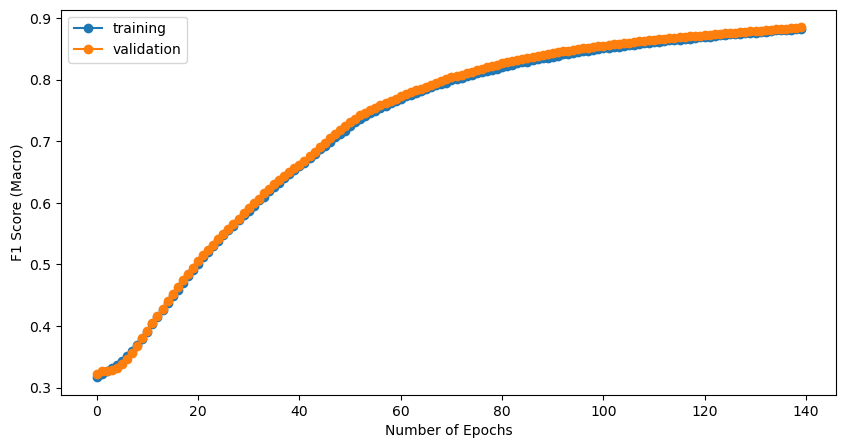

              precision    recall  f1-score   support

       black       0.91      0.94      0.92       974
       white       0.91      0.89      0.90       691
        blue       1.00      1.00      1.00        57
       brown       0.96      0.99      0.98      1173
        gray       0.94      0.91      0.92       778
      orange       1.00      0.96      0.98        70
         red       0.00      0.00      0.00         0
      yellow       1.00      0.94      0.97       139
     patches       0.92      0.95      0.94       737
       spots       0.94      0.81      0.87       382
     stripes       0.99      0.60      0.75       111
       furry       0.99      1.00      0.99      1421
    hairless       1.00      0.94      0.97       252
   toughskin       0.97      0.95      0.96       681
         big       0.98      0.99      0.99      1276
       small       0.96      0.91      0.94       535
     bulbous       0.94      0.94      0.94       934
        lean       0.89    

alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.69      0.98      0.81       864
grizzly+bear       0.82      0.70      0.76       690
killer+whale       0.88      0.69      0.78       231
      beaver       0.38      0.05      0.09       152
   dalmatian       0.33      0.72      0.45       442
 persian+cat       0.18      0.07      0.10       599
       skunk       0.15      0.22      0.18       157
          ox       0.39      0.89      0.54       588
         fox       0.64      0.81      0.71       540
   chihuahua       0.25      0.51      0.34       448
       otter       1.00      0.00      0.01       592
       zebra       0.98      0.23      0.37       942
         pig       0.09      0.04      0.05       558

    accuracy                           0.49      6803
   macro avg       0.52      0.45      0.40      6803
weighted avg       0.58      0.49      0.43      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.97569444 0.701449

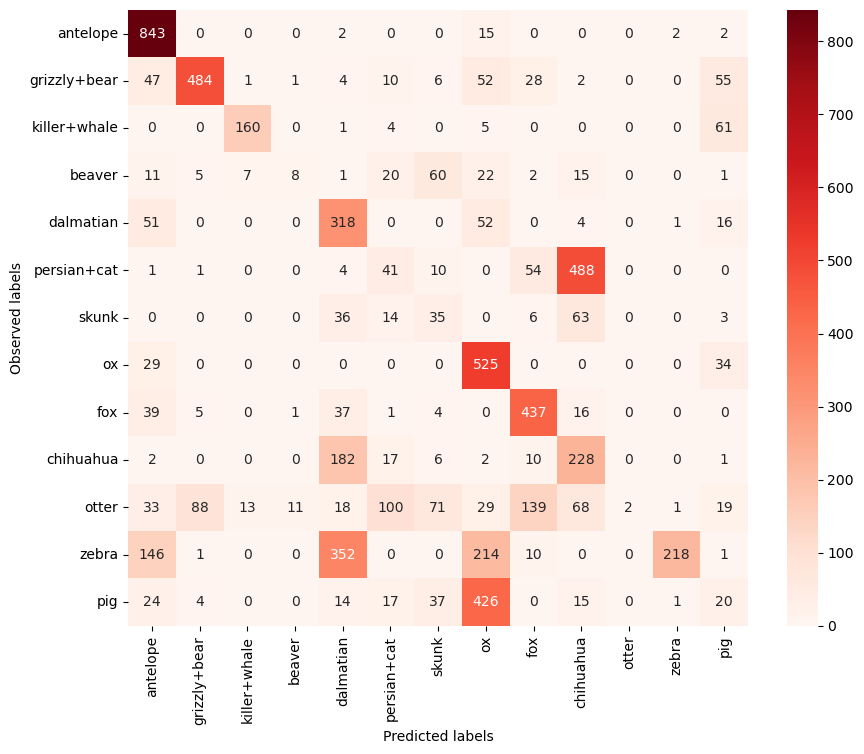

                precision    recall  f1-score   support

  ARTIODACTYLA       0.72      0.96      0.82      2241
     CARNIVORA       0.84      0.88      0.86      3468
PERISSODACTYLA       0.98      0.23      0.37       942
      RODENTIA       0.38      0.05      0.09       152

      accuracy                           0.79      6803
     macro avg       0.73      0.53      0.54      6803
  weighted avg       0.81      0.79      0.76      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.95671575 0.87572088 0.23142251 0.05263158]
Top_1_accuracy for UnSeen Validation split 01 -  0.529122678184407


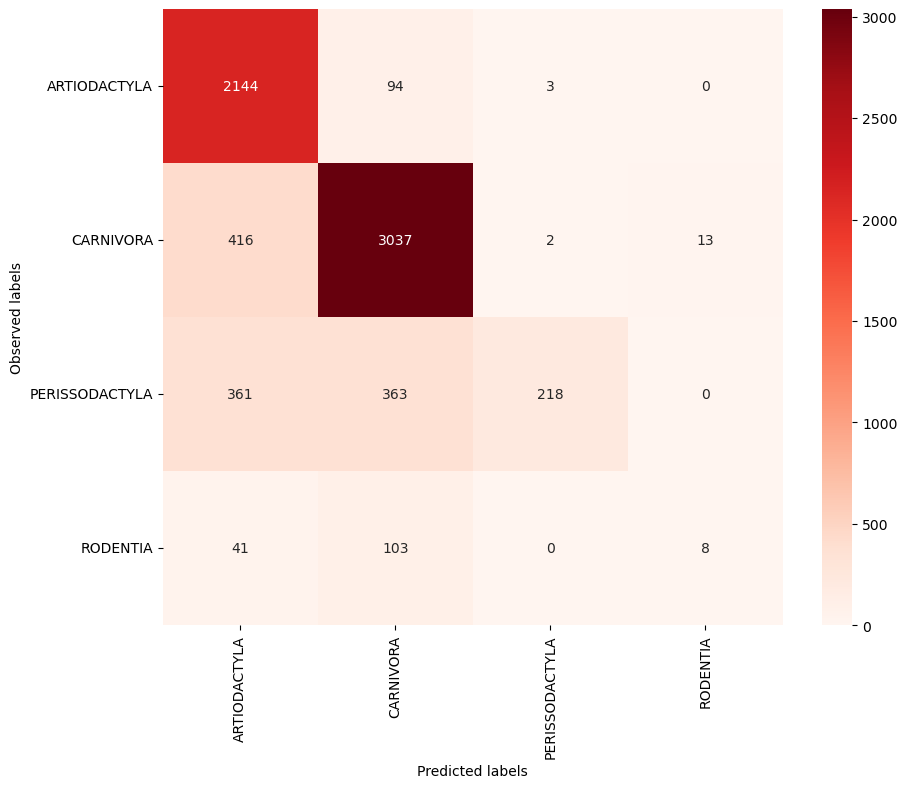

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6708474131262032 
               0         1
0       antelope  0.983796
1   grizzly+bear  0.742029
2   killer+whale  0.714286
3         beaver  0.138158
4      dalmatian  0.825792
5    persian+cat  0.585977
6          skunk  0.382166
7             ox  1.000000
8            fox  0.874074
9      chihuahua  0.953125
10         otter  0.045608
11         zebra  0.748408
12           pig  0.727599 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7518219019020724 
               0         1
0       antelope  0.998843
1   grizzly+bear  0.805797
2   killer+whale  0.727273
3         beaver  0.223684
4      dalmatian  0.959276
5    persian+cat  0.819699
6          skunk  0.547771
7             ox  1.000000
8            fox  0.931481
9      chihuahua  0.973214
10         otter  0.108108
11         zebra  0.857749
12           pig  0.820789 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8185146492012401 
               0         1
0  

In [30]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5339                0.3022        0.4796                0.3122     +  0.9024
      2        0.4743                0.3092        0.4657                0.3234     +  0.4919
      3        0.4652                0.3157        0.4590                0.3267     +  0.4785
      4        0.4589                0.3213        0.4530                0.3302     +  0.5103
      5        0.4530                0.3266        0.4470                0.3339     +  0.4828
      6        0.4467                0.3336        0.4406                0.3385     +  0.5412
      7        0.4401                0.3404        0.4337                0.3441     +  0.5168
      8        0.4330                0.3490        0.4263                0.3520     +  0.5675
      9        0.4253                0.3578    

     63        0.1857                0.7155        0.1823                0.7239     +  0.5271
     64        0.1840                0.7198        0.1806                0.7283     +  0.5056
     65        0.1823                0.7235        0.1789                0.7326     +  0.4874
     66        0.1806                0.7273        0.1773                0.7356     +  0.6132
     67        0.1789                0.7313        0.1757                0.7384     +  0.4855
     68        0.1774                0.7341        0.1741                0.7412     +  0.4856
     69        0.1758                0.7383        0.1726                0.7440     +  0.4859
     70        0.1742                0.7414        0.1711                0.7466     +  0.4940
     71        0.1730                0.7432        0.1696                0.7496     +  0.4899
     72        0.1714                0.7481        0.1682                0.7520     +  0.4750
     73        0.1701                0.7507        0.1668   

    127        0.1188                0.8598        0.1170                0.8594     +  0.5552
    128        0.1186                0.8603        0.1164                0.8611     +  0.5564
    129        0.1179                0.8618        0.1158                0.8623     +  0.5686
    130        0.1169                0.8628        0.1153                0.8630     +  0.5541
    131        0.1163                0.8645        0.1147                0.8645     +  0.5686
    132        0.1159                0.8645        0.1141                0.8655     +  0.5468
    133        0.1154                0.8657        0.1135                0.8663     +  0.5539
    134        0.1149                0.8660        0.1130                0.8674     +  0.5951
    135        0.1144                0.8678        0.1124                0.8683     +  0.5913
    136        0.1138                0.8684        0.1119                0.8692     +  0.5803
    137        0.1131                0.8687        0.1114   

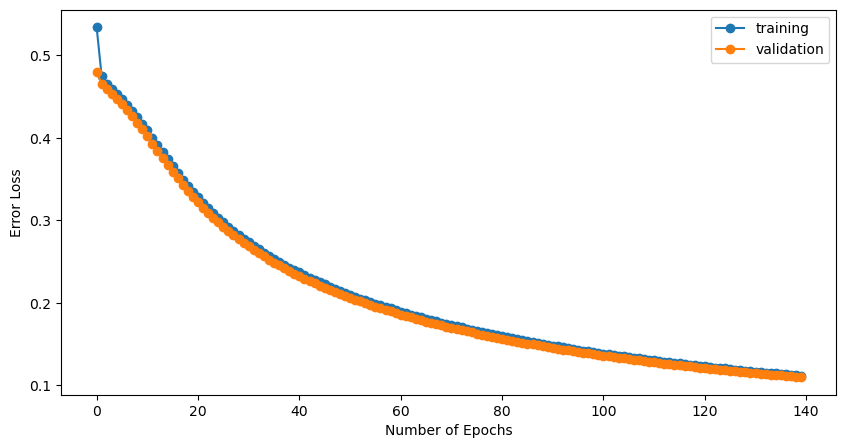

Trianing Recall Macro Curve


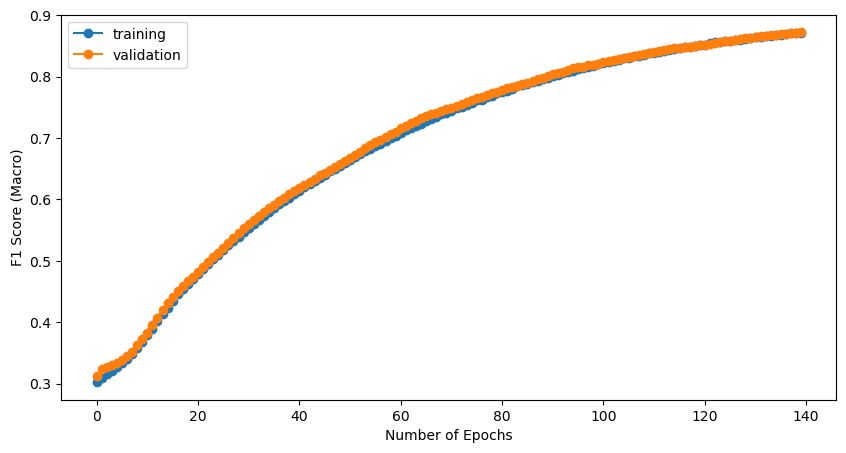

              precision    recall  f1-score   support

       black       0.92      0.95      0.93       918
       white       0.97      0.93      0.95       702
        blue       0.94      0.73      0.82        60
       brown       0.95      0.98      0.96      1025
        gray       0.92      0.79      0.85       451
      orange       0.96      0.85      0.90       124
         red       1.00      0.65      0.79        54
      yellow       1.00      0.88      0.94       139
     patches       0.91      0.86      0.88       566
       spots       0.87      0.71      0.78       339
     stripes       0.99      0.91      0.95       180
       furry       0.99      1.00      1.00      1463
    hairless       0.88      0.80      0.84       265
   toughskin       0.94      0.95      0.95       802
         big       0.98      0.99      0.98      1310
       small       0.95      0.89      0.92       396
     bulbous       0.95      0.97      0.96       911
        lean       0.96    

alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.42      0.69      0.52       400
         moose       0.47      0.77      0.59       554
humpback+whale       0.99      0.90      0.95       565
    chimpanzee       0.83      0.90      0.86       566
      squirrel       0.55      0.41      0.47       961
    rhinoceros       0.86      0.66      0.75       561
        rabbit       0.66      0.67      0.66       877
          wolf       0.61      0.74      0.67       470
     chihuahua       0.47      0.33      0.39       448
        weasel       0.07      0.42      0.12       222
   giant+panda       0.50      0.00      0.00       692
           pig       0.60      0.38      0.47       558
       raccoon       0.33      0.00      0.00       408

      accuracy                           0.53      7282
     macro avg       0.57      0.53      0.50      7282
  weighted avg       0.60      0.53      0.52      7282

Top_1_accuracy for UnSeen Validation split 01

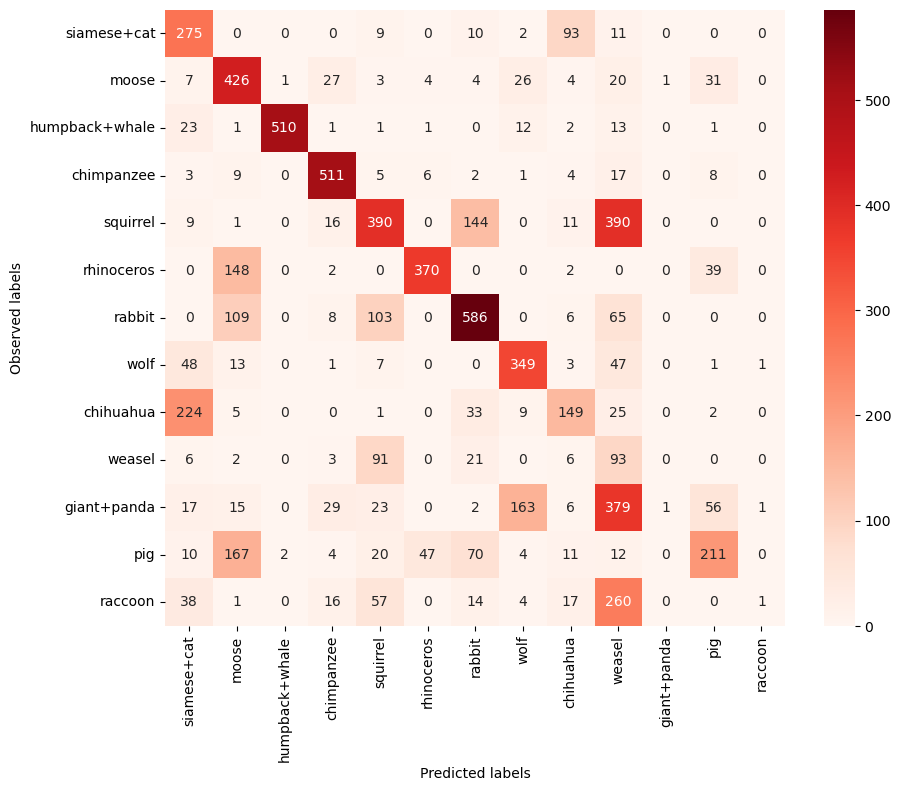

                precision    recall  f1-score   support

  ARTIODACTYLA       0.77      0.81      0.79      1677
     CARNIVORA       0.77      0.84      0.81      2640
    LAGOMORPHA       0.66      0.67      0.66       877
PERISSODACTYLA       0.86      0.66      0.75       561
      PRIMATES       0.83      0.90      0.86       566
      RODENTIA       0.55      0.41      0.47       961

      accuracy                           0.75      7282
     macro avg       0.74      0.71      0.72      7282
  weighted avg       0.74      0.75      0.74      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.80500894 0.84393939 0.668187   0.65953654 0.90282686 0.40582726]
Top_1_accuracy for UnSeen Validation split 01 -  0.71422099998401


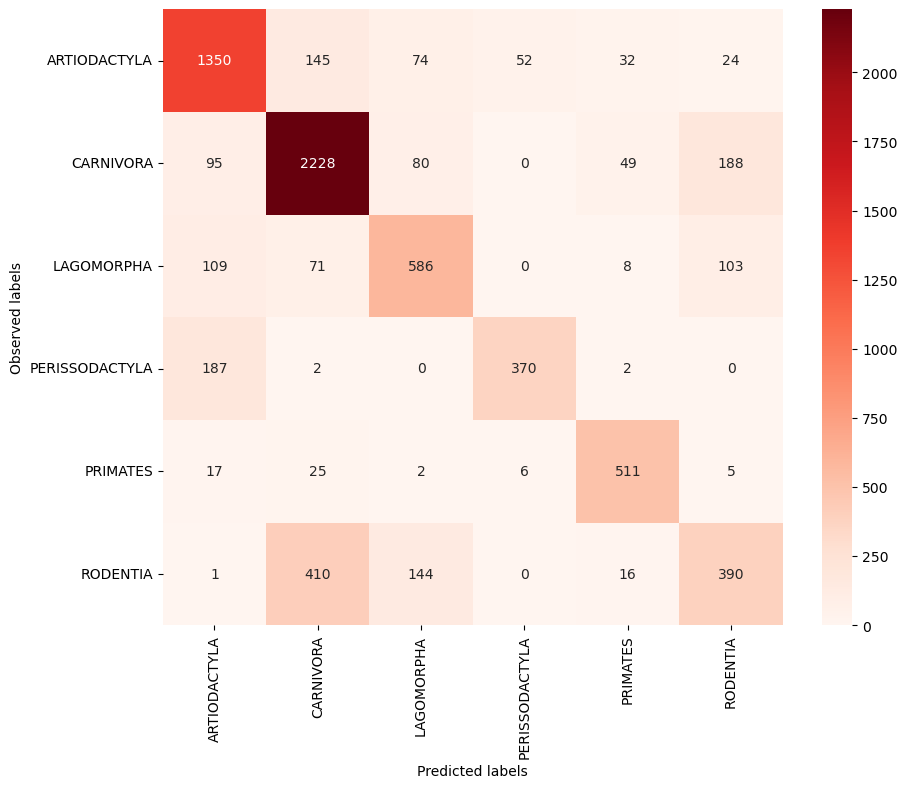

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7129281815955936 
                 0         1
0      siamese+cat  0.905000
1            moose  0.850181
2   humpback+whale  0.916814
3       chimpanzee  0.922261
4         squirrel  0.834547
5       rhinoceros  0.827094
6           rabbit  0.839225
7             wolf  0.872340
8        chihuahua  0.843750
9           weasel  0.693694
10     giant+panda  0.005780
11             pig  0.713262
12         raccoon  0.044118 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7925304569042539 
                 0         1
0      siamese+cat  0.942500
1            moose  0.879061
2   humpback+whale  0.930973
3       chimpanzee  0.943463
4         squirrel  0.900104
5       rhinoceros  0.992870
6           rabbit  0.970353
7             wolf  0.902128
8        chihuahua  0.928571
9           weasel  0.869369
10     giant+panda  0.020231
11             pig  0.810036
12         raccoon  0.213235 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [31]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 12. CZSL on Unseen Test Set

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.5256                0.3004        0.4859                0.2840     +  0.9519
      2        0.4835                0.3044        0.4763                0.2865     +  0.7634
      3        0.4753                0.3107        0.4687                0.2942     +  0.8504
      4        0.4674                0.3192        0.4604                0.3060     +  0.8406
      5        0.4586                0.3295        0.4512                0.3237     +  0.8274
      6        0.4489                0.3427        0.4410                0.3436     +  0.8166
      7        0.4383                0.3592        0.4300                0.3640     +  0.8626
      8        0.4268                0.3762        0.4185                0.3835     +  0.8485
      9        0.4153                0.3926    

     63        0.1928                0.7635        0.1883                0.7694     +  0.9155
     64        0.1914                0.7658        0.1870                0.7714     +  0.9662
     65        0.1903                0.7688        0.1857                0.7738     +  0.9153
     66        0.1888                0.7705        0.1845                0.7762     +  0.9235
     67        0.1874                0.7739        0.1832                0.7784     +  0.9359
     68        0.1862                0.7756        0.1820                0.7809     +  0.7885
     69        0.1850                0.7771        0.1808                0.7832     +  0.7972
     70        0.1840                0.7793        0.1796                0.7852     +  0.9134
     71        0.1828                0.7823        0.1784                0.7874     +  0.7721
     72        0.1817                0.7830        0.1773                0.7890     +  0.8548
     73        0.1805                0.7853        0.1762   

    127        0.1381                0.8573        0.1339                0.8647     +  0.8248
    128        0.1376                0.8583        0.1333                0.8654     +  0.8262
    129        0.1371                0.8593        0.1328                0.8661     +  0.9983
    130        0.1364                0.8595        0.1322                0.8670     +  0.7769
    131        0.1361                0.8606        0.1317                0.8677     +  0.7932
    132        0.1355                0.8614        0.1312                0.8686     +  0.8001
    133        0.1351                0.8615        0.1307                0.8693     +  0.7920
    134        0.1345                0.8630        0.1302                0.8701     +  0.8209
    135        0.1341                0.8634        0.1297                0.8709     +  0.9108
    136        0.1333                0.8644        0.1292                0.8714     +  0.8368
    137        0.1328                0.8649        0.1287   

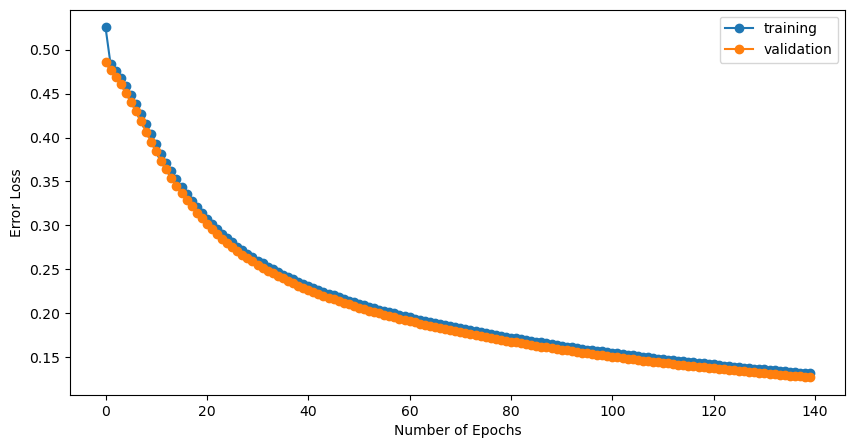

Trianing Recall Macro Curve


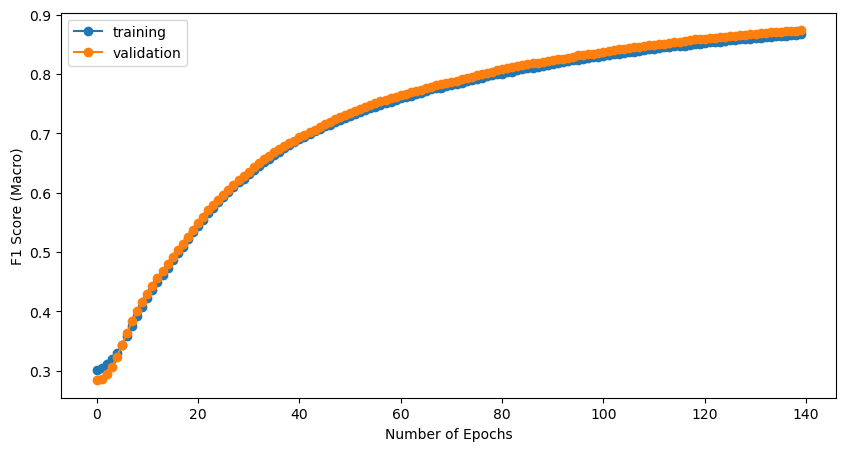

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.24      0.29      0.26      1645
  blue+whale       0.12      0.99      0.21       174
       sheep       0.49      0.82      0.61      1420
        seal       0.76      0.22      0.34       988
         bat       0.00      0.00      0.00       383
     giraffe       0.08      0.01      0.02      1202
         rat       0.45      0.81      0.58       310
      bobcat       0.84      0.88      0.86       630
      walrus       0.14      0.07      0.09       215
     dolphin       0.60      0.17      0.27       946

    accuracy                           0.38      7913
   macro avg       0.37      0.43      0.32      7913
weighted avg       0.41      0.38      0.34      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.28632219 0.99425287 0.81971831 0.22064777 0.         0.01331115
 0.80967742 0.88095238 0.06511628 0.1744186 ]
Top_1_accuracy for UnSeen Validation split 01 -  0.42644169772662455


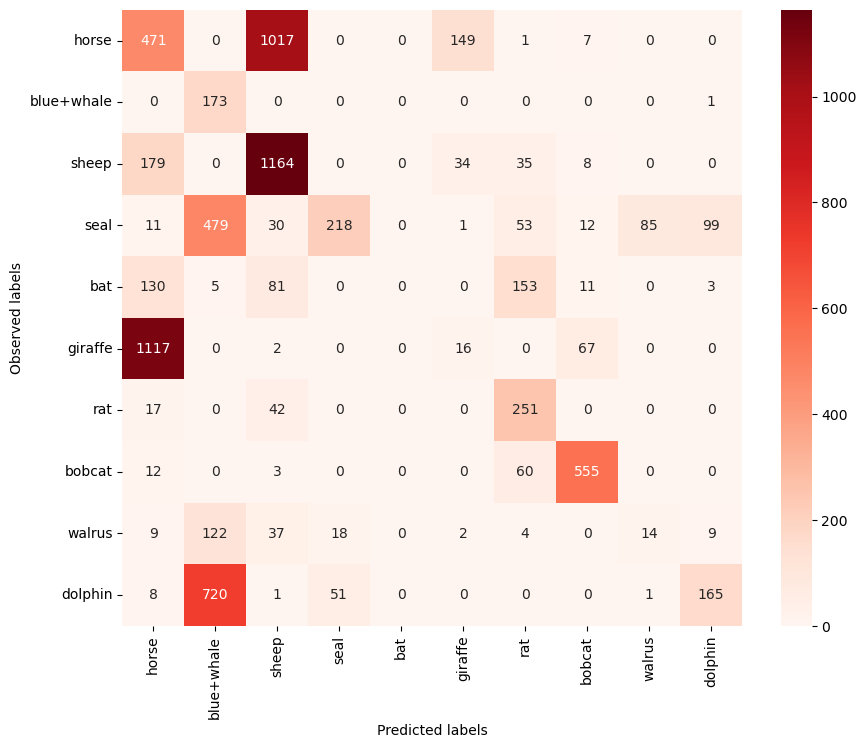

                precision    recall  f1-score   support

  ARTIODACTYLA       0.52      0.61      0.56      3742
     CARNIVORA       0.86      0.49      0.63      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.24      0.29      0.26      1645
      RODENTIA       0.45      0.81      0.58       310

      accuracy                           0.49      7913
     macro avg       0.42      0.44      0.41      7913
  weighted avg       0.51      0.49      0.49      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.60823089 0.49208947 0.         0.28632219 0.80967742]
Top_1_accuracy for UnSeen Validation split 01 -  0.43926399423767587


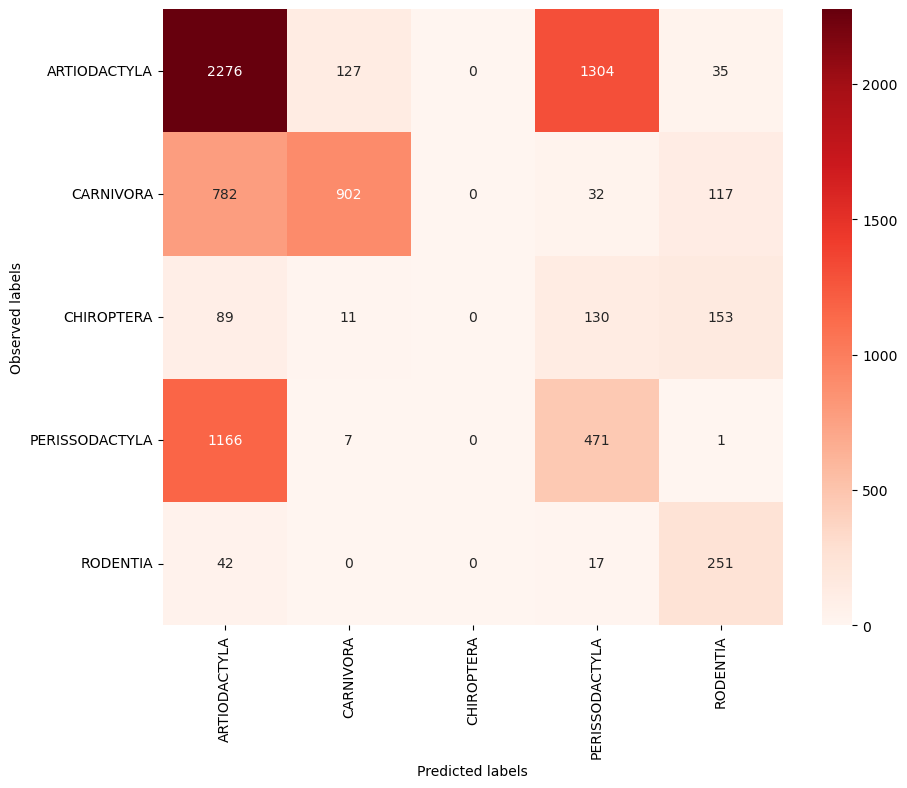

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6898790640895279 
            0         1
0       horse  0.842553
1  blue+whale  1.000000
2       sheep  0.925352
3        seal  0.426113
4         bat  0.010444
5     giraffe  0.890183
6         rat  0.877419
7      bobcat  0.982540
8      walrus  0.479070
9     dolphin  0.465116 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8111622068611574 
            0         1
0       horse  0.999392
1  blue+whale  1.000000
2       sheep  0.981690
3        seal  0.671053
4         bat  0.080940
5     giraffe  0.956739
6         rat  0.983871
7      bobcat  0.988889
8      walrus  0.590698
9     dolphin  0.858351 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8890349891729639 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.996479
3        seal  0.873482
4         bat  0.201044
5     giraffe  0.999168
6         rat  0.993548
7      bobcat  0.990476
8      walrus  0.837209
9     dolphin  0.9

In [28]:
Test = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 140, 
               bs = 44, 
               numunits = 725, 
               lr = 0.01672300858684881, 
               optimiser = nn.Sigmoid(), 
               dropout = .25897885389379416, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 12. CZSL on Unseen Test Set using unoptimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4123                0.3986        0.3250                0.5152     +  2.2882
      2        0.2783                0.5973        0.2416                0.6715     +  2.0490
      3        0.2225                0.7084        0.2029                0.7497     +  2.2540
      4        0.1924                0.7649        0.1788                0.7909     +  2.1428
      5        0.1721                0.8015        0.1612                0.8236     +  2.0038
      6        0.1564                0.8281        0.1476                0.8467     +  2.1029
      7        0.1443                0.8475        0.1368                0.8643     +  2.1922
      8        0.1346                0.8622        0.1278                0.8761     +  2.0340
      9        0.1262                0.8741    

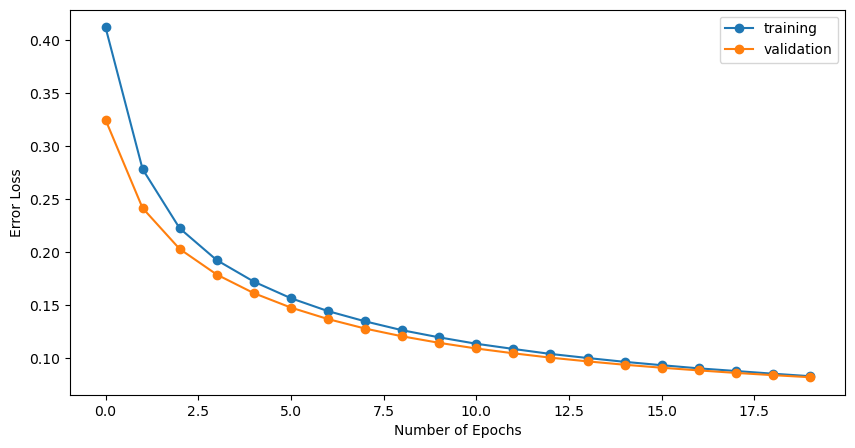

Trianing Recall Macro Curve


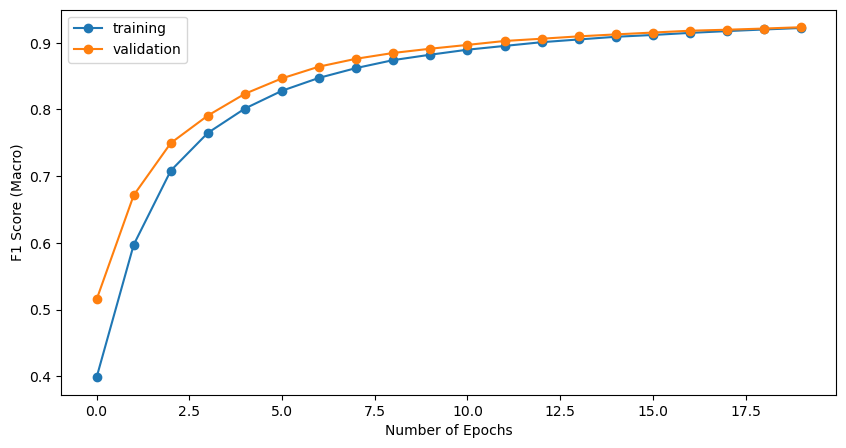

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.898930
[t-SNE] KL divergence after 1000 iterations: 0.250724


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.18      0.21      0.20      1645
  blue+whale       0.14      0.99      0.25       174
       sheep       0.43      0.70      0.53      1420
        seal       0.53      0.32      0.40       988
         bat       1.00      0.00      0.01       383
     giraffe       0.14      0.03      0.04      1202
         rat       0.41      0.86      0.55       310
      bobcat       0.80      0.83      0.81       630
      walrus       0.16      0.07      0.10       215
     dolphin       0.50      0.13      0.21       946

    accuracy                           0.35      7913
   macro avg       0.43      0.41      0.31      7913
weighted avg       0.40      0.35      0.31      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.21215805 0.99425287 0.70140845 0.31882591 0.00261097 0.02579035
 0.85806452 0.82857143 0.06976744 0.13424947]
Top_1_accuracy for UnSeen Validation split 01 -  0.41456994634046423


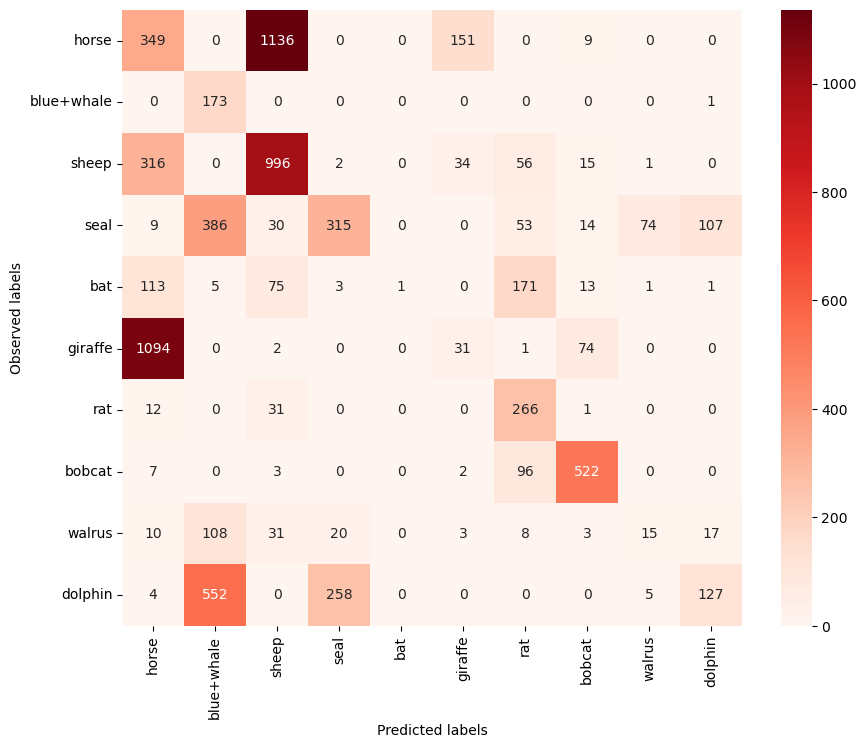

                precision    recall  f1-score   support

  ARTIODACTYLA       0.48      0.51      0.49      3742
     CARNIVORA       0.72      0.53      0.61      1833
    CHIROPTERA       1.00      0.00      0.01       383
PERISSODACTYLA       0.18      0.21      0.20      1645
      RODENTIA       0.41      0.86      0.55       310

      accuracy                           0.44      7913
     macro avg       0.56      0.42      0.37      7913
  weighted avg       0.49      0.44      0.44      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.51202565 0.52536825 0.00261097 0.21215805 0.85806452]
Top_1_accuracy for UnSeen Validation split 01 -  0.4220454880800629


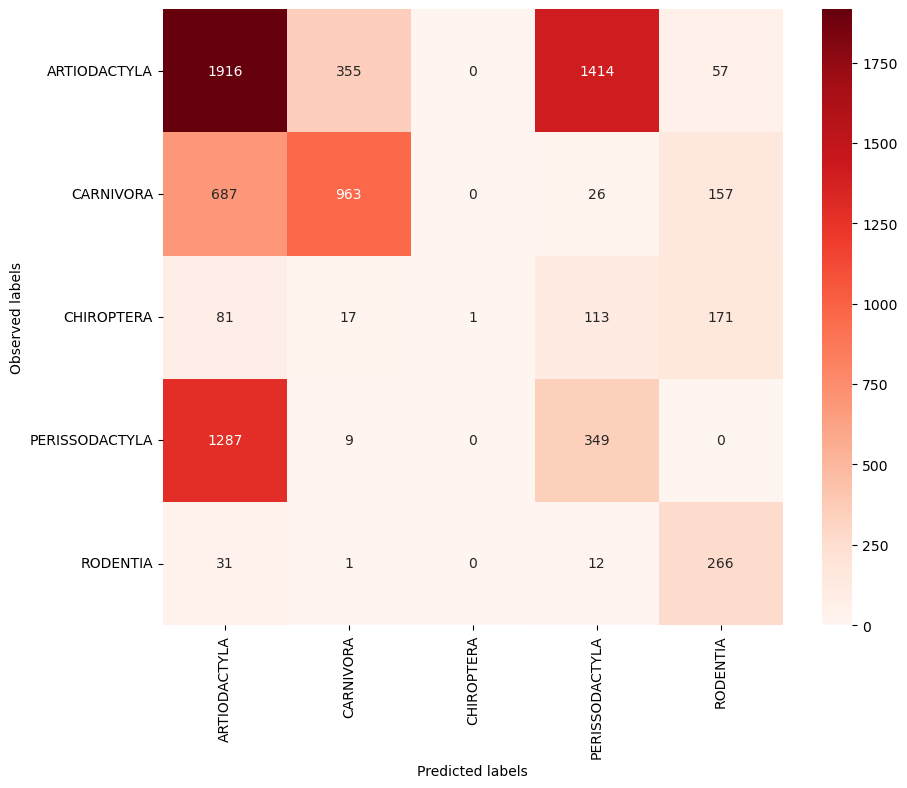

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6978563829335381 
            0         1
0       horse  0.782979
1  blue+whale  1.000000
2       sheep  0.877465
3        seal  0.493927
4         bat  0.026110
5     giraffe  0.897671
6         rat  0.925806
7      bobcat  0.977778
8      walrus  0.488372
9     dolphin  0.508457 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8193325125212217 
            0         1
0       horse  0.998784
1  blue+whale  1.000000
2       sheep  0.954930
3        seal  0.696356
4         bat  0.101828
5     giraffe  0.948419
6         rat  0.993548
7      bobcat  0.988889
8      walrus  0.627907
9     dolphin  0.882664 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8978648633525801 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.981690
3        seal  0.880567
4         bat  0.284595
5     giraffe  0.997504
6         rat  0.996774
7      bobcat  0.992063
8      walrus  0.846512
9     dolphin  0.9

In [50]:
Test02 = CZSL(mode = "Test", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 16, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Deterministic', 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 13. Hyperoptimisation with best distance metric and prediction output type

In [17]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Sigmoid())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, 85))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 8, 64)
    ep = trial.suggest_int("max_epoch", 5, 200)
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = 0,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,2:87])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,2:87])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,2:87])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [23]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="skorch example.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-06 19:09:39,665] A new study created in memory with name: no-name-769d8603-f68d-4b22-8fa4-169a77796883


Sequential(
  (0): Linear(in_features=2048, out_features=820, bias=True)
  (1): Dropout(p=0.3127455894478871, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=820, out_features=178, bias=True)
  (4): Dropout(p=0.3127455894478871, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=178, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=820, bias=True)
  (1): Dropout(p=0.3127455894478871, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=820, out_features=178, bias=True)
  (4): Dropout(p=0.3127455894478871, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=178, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=820, bias=True)
  (1): Dropout(p=0.3127455894478871, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=820, out_features=178, bias=True)
  (4): Dropout(p=0.3127455894478871, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=178, out_features=85, bias=True)
)
  epoch    train_loss 

     95        0.0010        0.0461                0.9547  1.3923
     96        0.0010        0.0459                0.9548  1.4983
     97        0.0010        0.0460                0.9549  1.4197
     98        0.0010        0.0451                0.9556  1.4505
     99        0.0011        0.0459                0.9547  1.4475
    100        0.0009        0.0457                0.9555  1.4028
    101        0.0009        0.0464                0.9550  1.6095
    102        0.0010        0.0467                0.9549  1.5219
    103        0.0010        0.0461                0.9550  1.4553
    104        0.0010        0.0462                0.9549  1.4194
    105        0.0009        0.0463                0.9554  1.4696
    106        0.0009        0.0471                0.9549  1.5127
    107        0.0009        0.0471                0.9548  1.4979
    108        0.0009        0.0462                0.9555  1.5122
    109        0.0009        0.0467                0.9550  1.4502
    110   

     48        0.0026        0.0355                0.9597  1.7443
     49        0.0026        0.0353                0.9597  1.6218
     50        0.0025        0.0359                0.9597  1.6568
     51        0.0025        0.0360                0.9598  1.4936
     52        0.0023        0.0354                0.9605  1.5520
     53        0.0024        0.0364                0.9587  1.6288
     54        0.0022        0.0366                0.9597  1.5086
     55        0.0022        0.0355                0.9603  1.5235
     56        0.0020        0.0370                0.9597  1.5115
     57        0.0019        0.0371                0.9598  1.4555
     58        0.0019        0.0366                0.9601  1.6008
     59        0.0019        0.0365                0.9600  1.5580
     60        0.0018        0.0374                0.9595  1.6071
     61        0.0017        0.0372                0.9597  1.6303
     62        0.0018        0.0376                0.9601  1.5813
     63   

      6        0.0372        0.0340                0.9403  1.5028
      7        0.0326        0.0320                0.9420  1.4554
      8        0.0282        0.0309                0.9434  1.3931
      9        0.0254        0.0302                0.9470  1.3897
     10        0.0228        0.0297                0.9512  1.4618
     11        0.0204        0.0293                0.9544  1.5265
     12        0.0185        0.0291                0.9558  1.5127
     13        0.0169        0.0290                0.9564  1.4666
     14        0.0155        0.0286                0.9563  1.4388
     15        0.0146        0.0289                0.9568  1.4891
     16        0.0133        0.0286                0.9569  1.5646
     17        0.0125        0.0289                0.9569  1.5883
     18        0.0110        0.0290                0.9570  1.4687
     19        0.0106        0.0289                0.9570  1.5103
     20        0.0098        0.0293                0.9574  1.4325
     21   

    117        0.0010        0.0417                0.9594  1.5227
    118        0.0011        0.0418                0.9591  1.5390
    119        0.0009        0.0425                0.9593  1.4723
    120        0.0011        0.0424                0.9589  1.6248
    121        0.0010        0.0426                0.9591  1.5780
    122        0.0009        0.0429                0.9588  1.5780
    123        0.0009        0.0423                0.9591  1.5120
    124        0.0011        0.0425                0.9588  1.5682
    125        0.0010        0.0424                0.9591  1.5270
    126        0.0010        0.0427                0.9591  1.5574
    127        0.0010        0.0432                0.9595  1.5431
    128        0.0010        0.0428                0.9589  1.5473
    129        0.0009        0.0432                0.9592  1.5334
    130        0.0010        0.0430                0.9592  1.7076
    131        0.0009        0.0436                0.9591  1.4976
    132   

[I 2022-12-06 19:21:57,348] Trial 0 finished with value: 0.48113333125446517 and parameters: {'lr': 0.19524729089641418, 'batch_size': 16, 'max_epoch': 157, 'n_layers': 2, 'dropout': 0.3127455894478871, 'n_units_l0': 820, 'n_units_l1': 178}. Best is trial 0 with value: 0.48113333125446517.


[0.49884337004278756, 0.4344499204035016, 0.5101067033171063]
Sequential(
  (0): Linear(in_features=2048, out_features=65, bias=True)
  (1): Dropout(p=0.4264485393056565, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=65, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=65, bias=True)
  (1): Dropout(p=0.4264485393056565, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=65, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=65, bias=True)
  (1): Dropout(p=0.4264485393056565, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=65, out_features=85, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.5303        0.3953                0.4319  0.5170
      2        0.3904        0.3121                0.5108  0.4956
      3        0.3258        0.2535                0.6005  0.5371
      4       

      5        0.2527        0.1870                0.7777  0.6049
      6        0.2289        0.1674                0.8091  0.5810
      7        0.2131        0.1524                0.8347  0.6262
      8        0.1992        0.1402                0.8486  0.5730
      9        0.1870        0.1303                0.8629  0.6035
     10        0.1777        0.1218                0.8726  0.6136
     11        0.1693        0.1147                0.8807  0.6218
     12        0.1621        0.1089                0.8883  0.6534
     13        0.1562        0.1037                0.8924  0.6720
     14        0.1508        0.0991                0.8978  0.5827
     15        0.1473        0.0954                0.9011  0.6909
     16        0.1419        0.0920                0.9041  0.6708
     17        0.1371        0.0887                0.9078  0.6010
     18        0.1345        0.0858                0.9105  0.6274
     19        0.1310        0.0833                0.9129  0.6654
     20   

     18        0.1214        0.0759                0.9028  0.5857
     19        0.1163        0.0735                0.9052  0.5572
     20        0.1132        0.0713                0.9081  0.4808
     21        0.1116        0.0694                0.9100  0.5365
     22        0.1098        0.0676                0.9121  0.5213
     23        0.1072        0.0661                0.9121  0.5512
     24        0.1045        0.0645                0.9136  0.4758
     25        0.1032        0.0632                0.9149  0.4836
     26        0.1023        0.0619                0.9172  0.4347
     27        0.0992        0.0607                0.9179  0.5302
     28        0.0980        0.0597                0.9192  0.5030
     29        0.0965        0.0587                0.9190  0.5444
     30        0.0936        0.0576                0.9204  0.5308
     31        0.0934        0.0567                0.9207  0.5040
     32        0.0914        0.0559                0.9219  0.5679
     33   

[I 2022-12-06 19:24:22,426] Trial 1 finished with value: 0.49933088367032114 and parameters: {'lr': 0.07203839558553027, 'batch_size': 51, 'max_epoch': 77, 'n_layers': 1, 'dropout': 0.4264485393056565, 'n_units_l0': 65}. Best is trial 1 with value: 0.49933088367032114.


[0.501952665272814, 0.4595685285183536, 0.5364714572197958]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.15146973106431283, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.15146973106431283, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.15146973106431283, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=85, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.7076        0.7011                0.4639  1.1247
      2        0.6969        0.6902                0.4476  0.9165
      3        0.6855        0.6764                0.4143  0.9705
      4        0.67

     85        0.2905        0.2408                0.6312  1.0320
     86        0.2909        0.2397                0.6333  0.9550
     87        0.2865        0.2383                0.6372  0.9690
     88        0.2870        0.2370                0.6399  0.9681
     89        0.2850        0.2359                0.6424  0.9449
     90        0.2844        0.2346                0.6440  0.9556
     91        0.2814        0.2335                0.6456  0.9380
     92        0.2806        0.2323                0.6472  0.9508
     93        0.2803        0.2312                0.6488  0.9826
     94        0.2796        0.2301                0.6501  1.0166
     95        0.2786        0.2290                0.6512  0.9374
     96        0.2765        0.2280                0.6526  1.0180
     97        0.2792        0.2271                0.6542  0.9609
     98        0.2760        0.2260                0.6555  0.9563
     99        0.2746        0.2249                0.6562  0.9877
    100   

     28        0.3277        0.2816                0.5821  0.9290
     29        0.3231        0.2783                0.5855  1.0154
     30        0.3203        0.2752                0.5910  0.9437
     31        0.3188        0.2724                0.5941  0.9525
     32        0.3150        0.2696                0.5982  1.0219
     33        0.3128        0.2667                0.6005  1.0482
     34        0.3100        0.2644                0.6047  1.0210
     35        0.3078        0.2616                0.6074  0.9803
     36        0.3042        0.2592                0.6106  0.9785
     37        0.3039        0.2569                0.6130  0.9595
     38        0.3033        0.2549                0.6172  0.9339
     39        0.3000        0.2526                0.6190  0.8948
     40        0.2982        0.2509                0.6230  0.9758
     41        0.2967        0.2491                0.6265  0.9934
     42        0.2962        0.2473                0.6303  0.9666
     43   

    121        0.2447        0.1945                0.7391  0.9811
    122        0.2433        0.1942                0.7396  1.0586
    123        0.2434        0.1938                0.7407  1.0427
    124        0.2428        0.1935                0.7408  1.0343
    125        0.2440        0.1932                0.7415  0.9023
    126        0.2440        0.1929                0.7416  0.9747
    127        0.2425        0.1926                0.7429  1.0222
    128        0.2428        0.1924                0.7429  1.1021
    129        0.2422        0.1920                0.7430  1.0074
    130        0.2430        0.1917                0.7425  1.0125
    131        0.2421        0.1914                0.7433  0.9726
    132        0.2418        0.1913                0.7449  0.9800
    133        0.2421        0.1910                0.7453  1.0665
    134        0.2413        0.1907                0.7448  1.0188
    135        0.2429        0.1905                0.7452  1.0078
    136   

     64        0.2909        0.2394                0.6180  1.0060
     65        0.2915        0.2382                0.6198  1.0148
     66        0.2903        0.2370                0.6233  1.0680
     67        0.2877        0.2358                0.6250  1.0213
     68        0.2876        0.2347                0.6271  0.9700
     69        0.2857        0.2334                0.6297  0.9478
     70        0.2873        0.2324                0.6333  0.9638
     71        0.2848        0.2315                0.6350  0.9620
     72        0.2831        0.2303                0.6368  0.9826
     73        0.2843        0.2295                0.6409  1.0211
     74        0.2817        0.2283                0.6427  0.9920
     75        0.2797        0.2274                0.6441  1.0009
     76        0.2788        0.2264                0.6461  0.9737
     77        0.2816        0.2256                0.6477  0.9295
     78        0.2776        0.2247                0.6529  1.0135
     79   

[I 2022-12-06 19:31:58,081] Trial 2 finished with value: 0.3517614910633757 and parameters: {'lr': 0.011015745410294793, 'batch_size': 26, 'max_epoch': 149, 'n_layers': 1, 'dropout': 0.15146973106431283, 'n_units_l0': 7}. Best is trial 1 with value: 0.49933088367032114.


[0.3702446647112836, 0.327540568501757, 0.3574992399770864]
Number of finished trials: 3
Best trial:
  Value: 0.49933088367032114
  Params: 
    lr: 0.07203839558553027
    batch_size: 51
    max_epoch: 77
    n_layers: 1
    dropout: 0.4264485393056565
    n_units_l0: 65


Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.3829                0.4389        0.2862                0.5965     +  1.5149
      2        0.2427                0.6662        0.2121                0.7384     +  1.3135
      3        0.1939                0.7605        0.1780                0.7982     +  1.2564
      4        0.1672                0.8088        0.1563                0.8352     +  1.2985
      5        0.1489                0.8403        0.1409                0.8593     +  1.3467
      6        0.1354                0.8605        0.1293                0.8758     +  1.3015
      7        0.1252                0.8740        0.1204                0.8851     +  1.2763
      8        0.1172                0.8842        0.1133                0.8929     +  1.3433
      9        0.1104                0.8921    

     63        0.0405                0.9582        0.0529                0.9499     +  1.2265
     64        0.0402                0.9587        0.0527                0.9499     +  1.2107
     65        0.0398                0.9590        0.0525                0.9501     +  1.3104
     66        0.0393                0.9592        0.0523                0.9502     +  1.3289
     67        0.0391                0.9599        0.0521                0.9503     +  1.3116
     68        0.0388                0.9599        0.0519                0.9504     +  1.2790
     69        0.0384                0.9600        0.0517                0.9507     +  1.2683
     70        0.0379                0.9603        0.0516                0.9507     +  1.2717
     71        0.0376                0.9609        0.0514                0.9510     +  1.2398
     72        0.0374                0.9608        0.0512                0.9511     +  1.2551
     73        0.0371                0.9615        0.0510   

    129        0.0234                0.9725        0.0460                0.9551     +  1.2857
    130        0.0234                0.9725        0.0459                0.9549     +  1.3129
    131        0.0232                0.9727        0.0459                0.9550     +  1.2741
    132        0.0230                0.9729        0.0458                0.9549     +  1.3427
    133        0.0228                0.9730        0.0458                0.9552     +  1.5453
    134        0.0226                0.9731        0.0457                0.9551     +  1.5065
    135        0.0225                0.9732        0.0457                0.9550     +  1.3951
    136        0.0225                0.9732        0.0457                0.9550     +  1.3435
    137        0.0221                0.9735        0.0456                0.9552     +  1.3754
    138        0.0221                0.9734        0.0456                0.9552     +  1.5639
    139        0.0219                0.9739        0.0455   

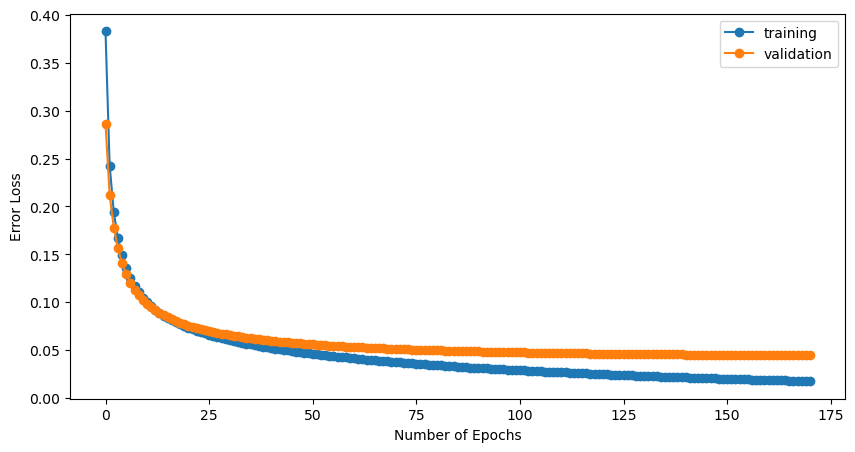

Trianing Recall Macro Curve


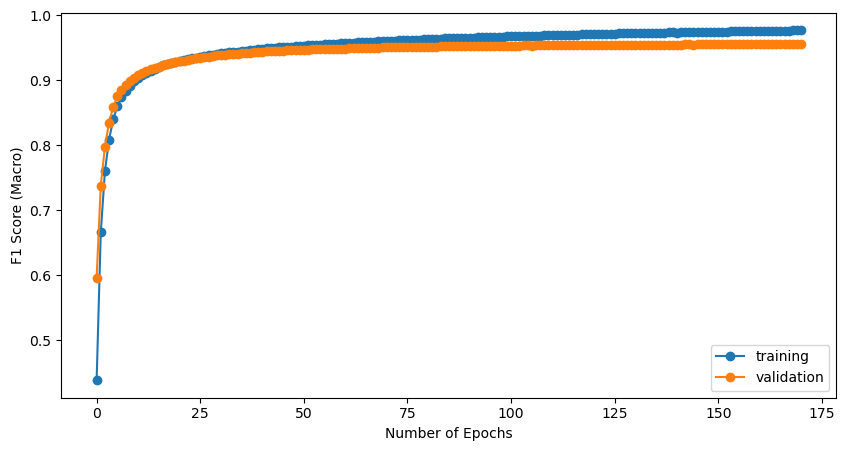

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes
[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.898930
[t-SNE] KL divergence after 1000 iterations: 0.250724


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.21      0.34      0.26      1645
  blue+whale       0.16      0.98      0.27       174
       sheep       0.35      0.33      0.34      1420
        seal       0.38      0.28      0.32       988
         bat       0.75      0.02      0.03       383
     giraffe       0.08      0.02      0.04      1202
         rat       0.36      0.98      0.52       310
      bobcat       0.79      0.86      0.82       630
      walrus       0.13      0.07      0.09       215
     dolphin       0.52      0.05      0.09       946

    accuracy                           0.31      7913
   macro avg       0.37      0.39      0.28      7913
weighted avg       0.35      0.31      0.27      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.34407295 0.98275862 0.33239437 0.27935223 0.0156658  0.02329451
 0.97741935 0.85555556 0.06511628 0.05179704]
Top_1_accuracy for UnSeen Validation split 01 -  0.3927426697064981


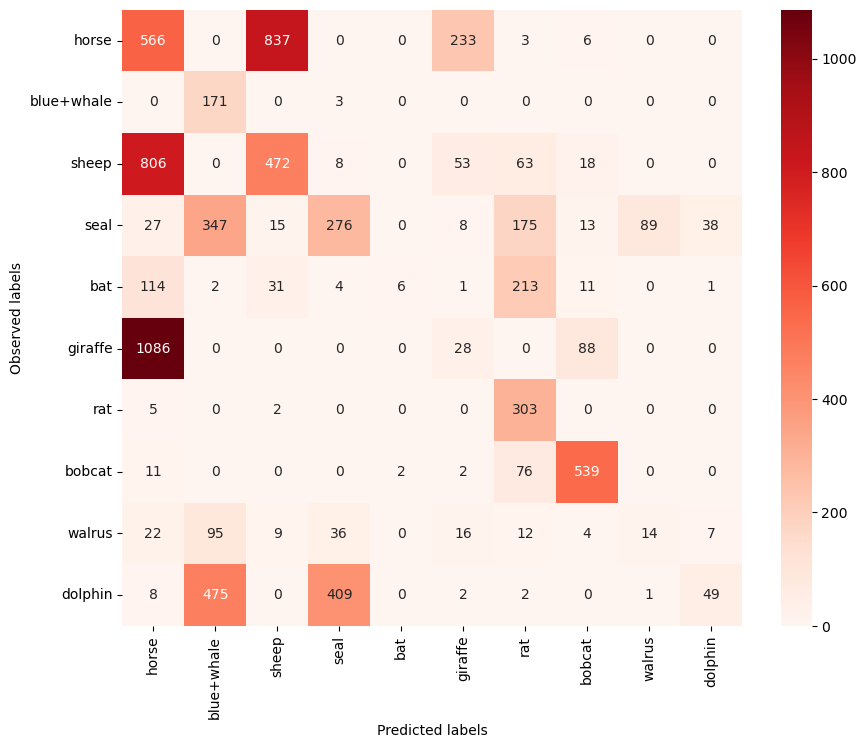

                precision    recall  f1-score   support

  ARTIODACTYLA       0.43      0.33      0.38      3742
     CARNIVORA       0.64      0.53      0.58      1833
    CHIROPTERA       0.75      0.02      0.03       383
PERISSODACTYLA       0.21      0.34      0.26      1645
      RODENTIA       0.36      0.98      0.52       310

      accuracy                           0.39      7913
     macro avg       0.48      0.44      0.35      7913
  weighted avg       0.45      0.39      0.39      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.33404596 0.52973268 0.0156658  0.34407295 0.97741935]
Top_1_accuracy for UnSeen Validation split 01 -  0.4401873485810439


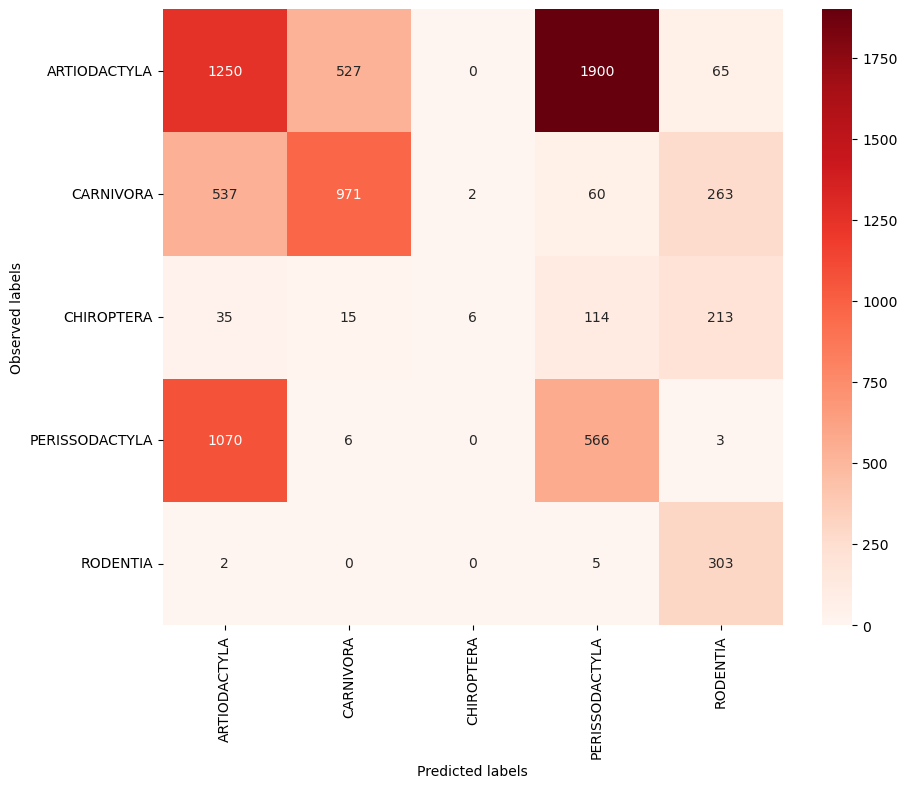

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.7014390744149608 
            0         1
0       horse  0.912462
1  blue+whale  0.988506
2       sheep  0.699296
3        seal  0.507085
4         bat  0.107050
5     giraffe  0.886023
6         rat  0.983871
7      bobcat  0.973016
8      walrus  0.493023
9     dolphin  0.464059 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8189172737499035 
            0         1
0       horse  0.999392
1  blue+whale  1.000000
2       sheep  0.895775
3        seal  0.739879
4         bat  0.261097
5     giraffe  0.940932
6         rat  1.000000
7      bobcat  0.985714
8      walrus  0.646512
9     dolphin  0.719873 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.9299856947550378 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.918310
3        seal  0.910931
4         bat  0.673629
5     giraffe  0.990017
6         rat  1.000000
7      bobcat  0.993651
8      walrus  0.818605
9     dolphin  0.9

In [24]:
Test = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 171, 
               bs = 51, 
               numunits = 1948, 
               lr = 0.2719805509673981, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.1288241363787712, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard